In [1]:
!pip install scikit-fuzzy

In [2]:
MOUNT_POINT = '/content/gdrive'
ROOT_PATH = MOUNT_POINT + "/My Drive/tfm"
DATA_PATH = ROOT_PATH + "/data"

import os
from google.colab import drive

drive.mount(MOUNT_POINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import io
import enum
import math
import random
import dataclasses
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from dateutil.relativedelta import relativedelta
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import IterativeImputer
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer
import io
import contextlib
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class TemporalSpace(enum.Enum):
    DAILY = enum.auto()
    WEEKLY = enum.auto()
    MONTHLY = enum.auto()

class EutrophicationLevel(enum.Enum):
    UNKNOWN = "DESCONOCIDO"
    OLIGOTROPHIC = "OLIGOTRÓFICO"
    MESOTROPHIC = "MESOTRÓFICO"
    EUTROPHIC = "EUTRÓFICO"
    HYPEREUTROPHIC = "HIPEREUTRÓFICO"

@dataclasses.dataclass
class Settings:
    temporal_space: TemporalSpace
    target_body: str
    predict_len: int = None

    def __post_init__(self):
        if self.temporal_space == TemporalSpace.MONTHLY:
            self.predict_len = 12
        if self.temporal_space == TemporalSpace.WEEKLY:
            self.predict_len = 52
        if self.temporal_space == TemporalSpace.DAILY:
            self.predict_len = 365

@dataclasses.dataclass
class ModelParameters:
    latent_dim: int = 36
    d_model: int = 128
    nhead: int = 8
    num_layers: int = 4

MAP_LEVELS = {
    EutrophicationLevel.UNKNOWN.value: -np.inf,
    EutrophicationLevel.OLIGOTROPHIC.value: 1,
    EutrophicationLevel.MESOTROPHIC.value: 2,
    EutrophicationLevel.EUTROPHIC.value: 3,
    EutrophicationLevel.HYPEREUTROPHIC.value: 4,
}

VAR_MAPS = {
    "DESCONOCIDO": EutrophicationLevel.UNKNOWN.value,
    "BAJO": EutrophicationLevel.OLIGOTROPHIC.value,
    "MODERADO": EutrophicationLevel.MESOTROPHIC.value,
    "ALTO": EutrophicationLevel.EUTROPHIC.value,
    "MUY ALTO": EutrophicationLevel.HYPEREUTROPHIC.value,
}

In [5]:
def process_data_in_temporal_space(dataset, temporal_space):
    # Copy dataset
    internal_dataset = dataset.copy()

    # Convert 'Sample Date' to datetime format
    internal_dataset['Sample Date'] = pd.to_datetime(internal_dataset['Sample Date'])

    # Process data based on temporal space
    if temporal_space == TemporalSpace.MONTHLY:
        return process_monthly_data(internal_dataset)

    if temporal_space == TemporalSpace.WEEKLY:
        return process_weekly_data(internal_dataset)

    if temporal_space == TemporalSpace.DAILY:
        return process_daily_data(internal_dataset)

def process_monthly_data(internal_dataset):
    # Extract Year and Month from 'Sample Date'
    internal_dataset['Year'] = internal_dataset['Sample Date'].dt.year
    internal_dataset['Month'] = internal_dataset['Sample Date'].dt.month

    # Create an empty DataFrame to store the results
    all_data = pd.DataFrame()

    # Process each Water Body separately
    for body, body_data in internal_dataset.groupby('Water Body'):
        # Group by Year and Month, calculating the mean for each group excluding non-numeric columns
        monthly_data = body_data.groupby(['Year', 'Month']).mean(numeric_only=True).reset_index()

        # Create a complete range of months from the minimum to the maximum date for this station
        start_date = body_data['Sample Date'].min() - relativedelta(months=1)  # Subtract one month from the start date
        end_date = body_data['Sample Date'].max()

        # Generate a complete date range with one entry per month
        all_months = pd.date_range(start=start_date, end=end_date, freq='MS')
        all_months_df = pd.DataFrame({'Year': all_months.year, 'Month': all_months.month})

        # Merge with the monthly data to ensure all months are represented, filling missing values with NaN
        body_monthly_data = pd.merge(all_months_df, monthly_data, on=['Year', 'Month'], how='left', sort=True)

        # Add the 'Water Body' column
        body_monthly_data['Water Body'] = body

        # Append to the overall DataFrame
        all_data = pd.concat([all_data, body_monthly_data], ignore_index=True)

    # Reorder columns to place 'Water Body' at the beginning
    columns_order = ['Water Body', 'Year', 'Month'] + [col for col in all_data.columns if col not in ['Water Body', 'Year', 'Month']]
    all_data = all_data[columns_order]

    return all_data

def process_weekly_data(internal_dataset):
    # Extract Year and Week from 'Sample Date'
    internal_dataset['Year'] = internal_dataset['Sample Date'].dt.isocalendar().year
    internal_dataset['Week'] = internal_dataset['Sample Date'].dt.isocalendar().week

    # Create an empty DataFrame to store the results
    all_data = pd.DataFrame()

    # Process each Water Body separately
    for body, body_data in internal_dataset.groupby('Water Body'):
        # Group by Year and Week, calculating the mean for each group excluding non-numeric columns
        weekly_data = body_data.groupby(['Year', 'Week']).mean(numeric_only=True).reset_index()

        # Create a complete range of weeks from the minimum to the maximum date for this station
        start_date = body_data['Sample Date'].min() - pd.DateOffset(weeks=1)  # Subtract one week from the start date
        end_date = body_data['Sample Date'].max()

        # Generate a complete date range with one entry per week (Monday as the start of the week)
        all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
        all_weeks_df = pd.DataFrame({'Year': all_weeks.isocalendar().year, 'Week': all_weeks.isocalendar().week})

        # Merge with the weekly data to ensure all weeks are represented, filling missing values with NaN
        body_weekly_data = pd.merge(all_weeks_df, weekly_data, on=['Year', 'Week'], how='left', sort=True)

        # Add the 'Water Body' column
        body_weekly_data['Water Body'] = body

        # Append to the overall DataFrame
        all_data = pd.concat([all_data, body_weekly_data], ignore_index=True)

    # Reorder columns to place 'Water Body' at the beginning
    columns_order = ['Water Body', 'Year', 'Week'] + [col for col in all_data.columns if col not in ['Water Body', 'Year', 'Week']]
    all_data = all_data[columns_order]

    return all_data

def process_daily_data(internal_dataset):
    # Extract Year, Month, and Day from 'Sample Date'
    internal_dataset['Year'] = internal_dataset['Sample Date'].dt.year
    internal_dataset['Month'] = internal_dataset['Sample Date'].dt.month
    internal_dataset['Day'] = internal_dataset['Sample Date'].dt.day

    # Create an empty DataFrame to store the results
    all_data = pd.DataFrame()

    # Process each Water Body separately
    for body, body_data in internal_dataset.groupby('Water Body'):
        # Group by Year, Month, and Day, calculating the mean for each group excluding non-numeric columns
        daily_data = body_data.groupby(['Year', 'Month', 'Day']).mean(numeric_only=True).reset_index()

        # Create a complete range of days from the minimum to the maximum date for this station
        start_date = body_data['Sample Date'].min()
        end_date = body_data['Sample Date'].max()

        # Generate a complete date range with one entry per day
        all_days = pd.date_range(start=start_date, end=end_date, freq='D')
        all_days_df = pd.DataFrame({'Year': all_days.year, 'Month': all_days.month, 'Day': all_days.day})

        # Merge with the daily data to ensure all days are represented, filling missing values with NaN
        body_daily_data = pd.merge(all_days_df, daily_data, on=['Year', 'Month', 'Day'], how='left', sort=True)

        # Add the 'Water Body' column
        body_daily_data['Water Body'] = body

        # Append to the overall DataFrame
        all_data = pd.concat([all_data, body_daily_data], ignore_index=True)

    # Reorder columns to place 'Water Body' at the beginning
    columns_order = ['Water Body', 'Year', 'Month', 'Day'] + [col for col in all_data.columns if col not in ['Water Body', 'Year', 'Month', 'Day']]
    all_data = all_data[columns_order]

    return all_data

In [6]:
def plot_original_vs_model(original_df, imputed_df, features, num_rows=50, labels=['Original', 'Imputed'], x_scale="Months"):
    """
    Función para graficar y comparar los datos originales contra los datos imputados usando seaborn en una sola gráfica.

    Se grafican dos variables por columna, de modo que la cantidad de gráficos varía dependiendo de la cantidad de características.

    :param original_df: DataFrame con los datos originales
    :param imputed_df: DataFrame con los datos imputados
    :param features: Lista de características a comparar (1-8 características)
    :param num_rows: Número de filas a mostrar en la gráfica
    """
    num_features = len(features)
    num_cols = 2
    num_rows_graphs = int(np.ceil(num_features / num_cols))

    fig, axes = plt.subplots(num_rows_graphs, num_cols, figsize=(16, 4 * num_rows_graphs), sharex=True)
    axes = axes.flatten() if num_features > 1 else [axes]

    # Iterar sobre cada característica y graficar
    for idx, feature in enumerate(features):
        ax = axes[idx]

        # Obtener los valores de las características originales y las imputadas
        original_values = original_df[feature].iloc[:num_rows]
        imputed_values = imputed_df[feature].iloc[:num_rows]
        x = np.arange(len(original_values))

        # Crear un DataFrame para los valores originales e imputados
        df_plot = pd.DataFrame({
            x_scale: x,
            labels[0]: original_values.values,
            labels[1]: imputed_values.values
        })

        # Graficar los valores imputados
        sns.lineplot(ax=ax, data=df_plot, x=x_scale, y=labels[1], label=labels[1], color='orange', linestyle='-', linewidth=1.5)

        # Graficar los valores originales solo donde no son NaN
        sns.lineplot(ax=ax, data=df_plot, x=x_scale, y=labels[0], label=labels[0], color='blue', linestyle='--', linewidth=1.5, marker='o')

        # Configuraciones adicionales
        ax.set_title(f"Comparación de {feature}")
        ax.set_xlabel(x_scale)
        ax.set_ylabel(feature)
        ax.legend(loc='upper right')

    # Eliminar gráficos vacíos si no hay suficientes características
    for idx in range(num_features, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [7]:
def plot_categorical_comparison(
        real_labels,
        predicted_labels,
        categories=['OLIGOTRÓFICO', 'MESOTRÓFICO', 'EUTRÓFICO', 'HIPEREUTRÓFICO'],
        title="Comparación de Categorías de Eutrofización",
        x_label="CATEGORÍA INFERIDA",
        y_label="CATEGORÍA TSI",
        title_fontsize=14,
        label_fontsize=12,
        tick_label_fontsize=10,
        annotation_fontsize=10,
        figsize=(8, 6)
    ):
    """
    Grafica una matriz de confusión comparando dos listas de categorías.

    Args:
        real_labels (list): Lista de categorías reales.
        predicted_labels (list): Lista de categorías predichas.
        categories (list, opcional): Lista de categorías que se esperan en los datos.
        title (str, opcional): Título del gráfico.
        x_label (str, opcional): Etiqueta del eje X.
        y_label (str, opcional): Etiqueta del eje Y.
        title_fontsize (int, opcional): Tamaño de fuente del título.
        label_fontsize (int, opcional): Tamaño de fuente de las etiquetas de los ejes.
        tick_label_fontsize (int, opcional): Tamaño de fuente de las etiquetas de los ticks.
        annotation_fontsize (int, opcional): Tamaño de fuente de las anotaciones de la matriz.
        figsize (tuple, opcional): Tamaño de la figura en pulgadas.
    """
    # Generar la matriz de confusión
    conf_matrix = confusion_matrix(real_labels, predicted_labels, labels=categories)

    # Crear un DataFrame de la matriz de confusión para facilitar la visualización
    df_conf_matrix = pd.DataFrame(conf_matrix, index=categories, columns=categories)

    # Configurar la visualización con Seaborn
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        df_conf_matrix,
        annot=True,
        cmap='Blues',
        fmt='d',
        cbar=True,
        xticklabels=categories,
        yticklabels=categories,
        annot_kws={"size": annotation_fontsize}
    )

    # Añadir títulos y etiquetas con los tamaños de fuente especificados
    plt.title(title, fontsize=title_fontsize, fontweight='bold')
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)

    # Ajustar el tamaño de las etiquetas de los ticks
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_label_fontsize)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_label_fontsize)

    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [8]:
def plot_training_history_sns(history, save_path=None):
    """
    Grafica las curvas de pérdida de entrenamiento y validación usando Seaborn.

    Parámetros:
    - history: Objeto History retornado por model.fit().
    - save_path: Ruta donde se guardará la gráfica. Si es None, se mostrará en pantalla.
    """
    # Configurar el estilo de Seaborn
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    # Extraer datos del historial
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    # Crear un DataFrame para facilitar la graficación con Seaborn
    df_loss = pd.DataFrame({
        'Época': epochs,
        'Pérdida de Entrenamiento': loss,
        'Pérdida de Validación': val_loss
    })

    # Transformar el DataFrame a formato largo (long-form) para Seaborn
    df_long = df_loss.melt(id_vars='Época',
                           value_vars=['Pérdida de Entrenamiento', 'Pérdida de Validación'],
                           var_name='Tipo de Pérdida',
                           value_name='Valor')

    # Crear la gráfica usando Seaborn
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_long, x='Época', y='Valor', hue='Tipo de Pérdida')

    # Añadir títulos y etiquetas
    plt.title('Curva de Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (MSE)')
    plt.legend(title='Tipo de Pérdida')

    # Mostrar o guardar la gráfica
    if save_path:
        plt.savefig(save_path)
        print(f"Gráfica guardada en: {save_path}")
    else:
        plt.show()

    # Cerrar la figura para liberar memoria
    plt.close()

In [9]:
samples = pd.read_parquet(f"{DATA_PATH}/samples_refined_water_bodies.parquet")

In [10]:
samples['Water Body'].value_counts()

,count
Water Body,
LAGO KASUMIGAURA,1621
LAGO MJOSA,1033
LAGO ONTARIO,615
LAGO ESTERO DE MEZCALA,105
LAGO MAZAIS BALTEZERS,98


In [11]:
_config = Settings(
    temporal_space=TemporalSpace.MONTHLY,
    target_body='LAGO ONTARIO'                                              # 'LAGO KASUMIGAURA', 'LAGO MJOSA', 'LAGO ONTARIO', 'LAGO ESTERO DE MEZCALA', 'LAGO MAZAIS BALTEZERS'
)

In [12]:
target_data = samples[samples['Water Body'] == _config.target_body]
target_data.reset_index(drop=True, inplace=True)

In [13]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 39 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Water Body   615 non-null    object 
 1   Sample Date  615 non-null    object 
 2   Chl_a        205 non-null    float64
 3   DIN          0 non-null      float64
 4   DKN          60 non-null     float64
 5   NH3N         184 non-null    float64
 6   NH4N         0 non-null      float64
 7   NOxN         319 non-null    float64
 8   NO2N         0 non-null      float64
 9   NO3N         0 non-null      float64
 10  PN           61 non-null     float64
 11  PON          11 non-null     float64
 12  TDN          0 non-null      float64
 13  TKN          0 non-null      float64
 14  TN           0 non-null      float64
 15  TON          0 non-null      float64
 16  DON          0 non-null      float64
 17  DIP          0 non-null      float64
 18  DRP          279 non-null    float64
 19  TDP     

In [14]:
data_date = target_data.copy()
data_date['Sample Date'] = pd.to_datetime(data_date['Sample Date'])
data_date.drop(columns=['Water Body'], inplace=True)
data_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Sample Date  615 non-null    datetime64[ns]
 1   Chl_a        205 non-null    float64       
 2   DIN          0 non-null      float64       
 3   DKN          60 non-null     float64       
 4   NH3N         184 non-null    float64       
 5   NH4N         0 non-null      float64       
 6   NOxN         319 non-null    float64       
 7   NO2N         0 non-null      float64       
 8   NO3N         0 non-null      float64       
 9   PN           61 non-null     float64       
 10  PON          11 non-null     float64       
 11  TDN          0 non-null      float64       
 12  TKN          0 non-null      float64       
 13  TN           0 non-null      float64       
 14  TON          0 non-null      float64       
 15  DON          0 non-null      float64       
 16  DIP     

In [15]:
print(f"{data_date['Sample Date'].min()} - {data_date['Sample Date'].max()}")

1979-03-22 00:00:00 - 2006-10-27 00:00:00


In [16]:
diff_months = (data_date['Sample Date'].max() - data_date['Sample Date'].min())
print(f"Diferencia en meses: {(diff_months.days / 30.44):.2f}")

Diferencia en meses: 331.18


In [17]:
data_group = data_date.groupby('Sample Date').mean().reset_index()
data_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Sample Date  593 non-null    datetime64[ns]
 1   Chl_a        205 non-null    float64       
 2   DIN          0 non-null      float64       
 3   DKN          38 non-null     float64       
 4   NH3N         175 non-null    float64       
 5   NH4N         0 non-null      float64       
 6   NOxN         307 non-null    float64       
 7   NO2N         0 non-null      float64       
 8   NO3N         0 non-null      float64       
 9   PN           39 non-null     float64       
 10  PON          7 non-null      float64       
 11  TDN          0 non-null      float64       
 12  TKN          0 non-null      float64       
 13  TN           0 non-null      float64       
 14  TON          0 non-null      float64       
 15  DON          0 non-null      float64       
 16  DIP     

In [18]:
base_columns = [
    "Chl_a",
    "DIN",
    "DKN",
    "NH3N",
    "NH4N",
    "NOxN",
    "NO2N",
    "NO3N",
    "PN",
    "PON",
    "TDN",
    "TKN",
    "TN",
    "TON",
    "DON",
    "DIP",
    "DRP",
    "TDP",
    "TIP",
    "TP",
    "TRP",
    "TPP",
    "BOD",
    "COD",
    "O2_Dis",
    "PV",
    "TDS",
    "TS",
    "TSS",
    "FDS",
    "FS",
    "VDS",
    "VS",
    "TRANS",
    "TURB",
    "TEMP",
    "pH",
]
non_null_columns = data_group.columns[data_group.notna().any()].tolist()
numeric_columns = [col for col in base_columns if col in non_null_columns]
numeric_columns

['Chl_a',
 'DKN',
 'NH3N',
 'NOxN',
 'PN',
 'PON',
 'DRP',
 'TDP',
 'TP',
 'O2_Dis',
 'TRANS',
 'TEMP',
 'pH']

In [19]:
data = data_group[numeric_columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chl_a   205 non-null    float64
 1   DKN     38 non-null     float64
 2   NH3N    175 non-null    float64
 3   NOxN    307 non-null    float64
 4   PN      39 non-null     float64
 5   PON     7 non-null      float64
 6   DRP     277 non-null    float64
 7   TDP     38 non-null     float64
 8   TP      392 non-null    float64
 9   O2_Dis  486 non-null    float64
 10  TRANS   375 non-null    float64
 11  TEMP    592 non-null    float64
 12  pH      436 non-null    float64
dtypes: float64(13)
memory usage: 60.4 KB


In [20]:
class NivelNitrogeno:
    def __init__(self, custom_vars=dict(), **kwargs):
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.nivel_nitrogeno = np.nan

        # Orden de prioridad de las variables
        self.priority_variables = [
            'TN', 'TDN', 'TKN', 'DIN', 'NOxN', 'NH4N', 'NO3N', 'NO2N',
            'DKN', 'NH3N', 'DON', 'PN', 'PON', 'TON'
        ]

        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        if not self.available_vars:
            raise ValueError(f"No se encontraron variables válidas para inferencia.")

        self._init_variables()
        self._crear_sistema_difuso()

    def _init_variables(self):
        self.base_vars = dict(
            DIN=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.2, 0.5]},
                    'MODERADO': {'type': 'trimf', 'params': [0.3, 0.8, 1.3]},
                    'ALTO': {'type': 'trimf', 'params': [1, 1.8, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3, 5, 5]}
                }
            ),
            DKN=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.2, 0.5]},
                    'MODERADO': {'type': 'trimf', 'params': [0.3, 0.8, 1.3]},
                    'ALTO': {'type': 'trimf', 'params': [1, 1.8, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3, 5, 5]}
                }
            ),
            NH3N=dict(
                universe = np.arange(0, 1.01, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.02, 0.05]},
                    'MODERADO': {'type': 'trimf', 'params': [0.03, 0.1, 0.2]},
                    'ALTO': {'type': 'trimf', 'params': [0.15, 0.3, 0.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.4, 0.6, 1, 1]}
                }
            ),
            NH4N=dict(
                universe = np.arange(0, 2.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.05, 0.1]},
                    'MODERADO': {'type': 'trimf', 'params': [0.08, 0.2, 0.4]},
                    'ALTO': {'type': 'trimf', 'params': [0.3, 0.6, 1]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.8, 1.5, 2, 2]}
                }
            ),
            NOxN=dict(
                universe = np.arange(0, 10.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.5, 1]},
                    'MODERADO': {'type': 'trimf', 'params': [0.8, 2, 3.5]},
                    'ALTO': {'type': 'trimf', 'params': [3, 5, 7]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [6.5, 8, 10, 10]}
                }
            ),
            NO2N=dict(
                universe = np.arange(0, 1.01, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.01, 0.03]},
                    'MODERADO': {'type': 'trimf', 'params': [0.02, 0.05, 0.1]},
                    'ALTO': {'type': 'trimf', 'params': [0.08, 0.2, 0.4]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.35, 0.6, 1, 1]}
                }
            ),
            NO3N=dict(
                universe = np.arange(0, 10.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.5, 1]},
                    'MODERADO': {'type': 'trimf', 'params': [0.8, 2, 3.5]},
                    'ALTO': {'type': 'trimf', 'params': [3, 5, 7]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [6.5, 8, 10, 10]}
                }
            ),
            PN=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.1, 0.3]},
                    'MODERADO': {'type': 'trimf', 'params': [0.2, 0.5, 1]},
                    'ALTO': {'type': 'trimf', 'params': [0.8, 1.5, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3.5, 5, 5]}
                }
            ),
            PON=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.1, 0.3]},
                    'MODERADO': {'type': 'trimf', 'params': [0.2, 0.5, 1]},
                    'ALTO': {'type': 'trimf', 'params': [0.8, 1.5, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3.5, 5, 5]}
                }
            ),
            TDN=dict(
                universe = np.arange(0, 10.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.5, 1]},
                    'MODERADO': {'type': 'trimf', 'params': [0.5, 1.5, 2.5]},
                    'ALTO': {'type': 'trimf', 'params': [2, 3.5, 5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [4.5, 7, 10, 10]}
                }
            ),
            TKN=dict(
                universe = np.arange(0, 10.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.3, 0.8]},
                    'MODERADO': {'type': 'trimf', 'params': [0.5, 1.5, 2.5]},
                    'ALTO': {'type': 'trimf', 'params': [2, 3.5, 5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [4.5, 7, 10, 10]}
                }
            ),
            TN=dict(
                universe = np.arange(0, 10.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.5, 1]},
                    'MODERADO': {'type': 'trimf', 'params': [0.5, 1.5, 2.5]},
                    'ALTO': {'type': 'trimf', 'params': [2, 3.5, 5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [4.5, 7, 10, 10]}
                }
            ),
            TON=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.1, 0.3]},
                    'MODERADO': {'type': 'trimf', 'params': [0.2, 0.5, 1]},
                    'ALTO': {'type': 'trimf', 'params': [0.8, 1.5, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3.5, 5, 5]}
                }
            ),
            DON=dict(
                universe = np.arange(0, 5.1, 0.1),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.1, 0.3]},
                    'MODERADO': {'type': 'trimf', 'params': [0.2, 0.5, 1]},
                    'ALTO': {'type': 'trimf', 'params': [0.8, 1.5, 2.5]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [2, 3.5, 5, 5]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _get_variable_definitions(self, var_name):
        var_content = self.base_vars.get(var_name, None)

        if var_content:
            universe = var_content['universe']
            mf_definitions = var_content['mf_definitions']
        else:
            raise ValueError(f"Variable desconocida: {var_name}")

        return universe, mf_definitions

    def _crear_sistema_difuso(self):
        # Inicializar estructuras
        self.rules = []
        self.variables = {}
        self.mf_definitions = {}
        self.calculation_method = None  # Método utilizado para el cálculo

        # Opción 1: Variable ideal - TN (Total Nitrogen)
        if 'TN' in self.available_vars:
            self.calculation_method = 'TN'
            # Definir variable difusa para TN
            universe, mf_definitions = self._get_variable_definitions('TN')
            antecedent = ctrl.Antecedent(universe, 'TN')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TN'] = antecedent

        # Opción 2: Calcular TN a partir de TDN y PN
        elif 'TDN' in self.available_vars and 'PN' in self.available_vars:
            self.calculation_method = 'TDN_PN'
            # Definir variable difusa para TN (calculado)
            universe, mf_definitions = self._get_variable_definitions('TN')
            antecedent = ctrl.Antecedent(universe, 'TN')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TN'] = antecedent

        # Opción 3: Calcular TN a partir de TKN y NOxN
        elif 'TKN' in self.available_vars and 'NOxN' in self.available_vars:
            self.calculation_method = 'TKN_NOxN'
            # Definir variable difusa para TN (calculado)
            universe, mf_definitions = self._get_variable_definitions('TN')
            antecedent = ctrl.Antecedent(universe, 'TN')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TN'] = antecedent

        # Opción 4: Usar variables individuales
        else:
            for var_name in self.priority_variables:
                if var_name in self.available_vars:
                    self.calculation_method = var_name
                    universe, mf_definitions = self._get_variable_definitions(var_name)
                    antecedent = ctrl.Antecedent(universe, var_name)
                    for label, params in mf_definitions.items():
                        if params['type'] == 'trapmf':
                            antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                        elif params['type'] == 'trimf':
                            antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
                    self.variables[var_name] = antecedent
                    break
            else:
                raise ValueError("No se encontraron variables válidas para inferencia.")

        # Definir variable de salida
        self.nivel_nitrogeno_universe = np.arange(0, 1.01, 0.01)
        self.nivel_nitrogeno_var = ctrl.Consequent(self.nivel_nitrogeno_universe, 'nivel_nitrogeno')
        self.nivel_nitrogeno_var['BAJO'] = fuzz.trapmf(self.nivel_nitrogeno_var.universe, [0, 0, 0.15, 0.3])
        self.nivel_nitrogeno_var['MODERADO'] = fuzz.trimf(self.nivel_nitrogeno_var.universe, [0.25, 0.4, 0.55])
        self.nivel_nitrogeno_var['ALTO'] = fuzz.trimf(self.nivel_nitrogeno_var.universe, [0.5, 0.65, 0.8])
        self.nivel_nitrogeno_var['MUY ALTO'] = fuzz.trapmf(self.nivel_nitrogeno_var.universe, [0.75, 0.85, 1, 1])

        # Definir reglas difusas
        if self.calculation_method in ['TN', 'TDN_PN', 'TKN_NOxN']:
            # Reglas basadas en TN
            self.rules.append(ctrl.Rule(self.variables['TN']['BAJO'], self.nivel_nitrogeno_var['BAJO']))
            self.rules.append(ctrl.Rule(self.variables['TN']['MODERADO'], self.nivel_nitrogeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(self.variables['TN']['ALTO'], self.nivel_nitrogeno_var['ALTO']))
            self.rules.append(ctrl.Rule(self.variables['TN']['MUY ALTO'], self.nivel_nitrogeno_var['MUY ALTO']))
        else:
            # Reglas basadas en variables individuales
            var_name = self.calculation_method
            antecedent = self.variables[var_name]
            self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_nitrogeno_var['BAJO']))
            self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_nitrogeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_nitrogeno_var['ALTO']))
            self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_nitrogeno_var['MUY ALTO']))

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def calcular_inferencia(self):
        if not hasattr(self, 'simulation'):
            raise ValueError("No ha sido posible crear el sistema de control.")

        # Opción 1: Usando TN directamente
        if self.calculation_method == 'TN':
            tn_value = self.available_vars['TN']
            self.simulation.input['TN'] = tn_value

        # Opción 2: Calcular TN a partir de TDN y PN
        elif self.calculation_method == 'TDN_PN':
            tdn_value = self.available_vars['TDN']
            pn_value = self.available_vars['PN']
            tn_value = tdn_value + pn_value
            self.simulation.input['TN'] = tn_value

        # Opción 3: Calcular TN a partir de TKN y NOxN
        elif self.calculation_method == 'TKN_NOxN':
            tkn_value = self.available_vars['TKN']
            noxn_value = self.available_vars['NOxN']
            tn_value = tkn_value + noxn_value
            self.simulation.input['TN'] = tn_value

        # Opción 4: Usar variables individuales
        else:
            var_name = self.calculation_method
            self.simulation.input[var_name] = self.available_vars[var_name]

        # Realizar la computación
        try:
            self.simulation.compute()
            self.nivel_nitrogeno = self.simulation.output['nivel_nitrogeno']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        return self.calculation_method

    def obtener_etiqueta(self):
        if np.isnan(self.nivel_nitrogeno):
            raise ValueError("El nivel de nitrógeno no está disponible.")

        # Crear un diccionario para almacenar los grados de pertenencia
        grados_pertenencia = {}

        # Para cada etiqueta en la variable de salida
        for etiqueta in self.nivel_nitrogeno_var.terms:
            # Obtener la función de pertenencia correspondiente
            funcion_pertenencia = self.nivel_nitrogeno_var[etiqueta].mf
            # Calcular el grado de pertenencia del valor de salida en esta función
            grado = fuzz.interp_membership(self.nivel_nitrogeno_var.universe, funcion_pertenencia, self.nivel_nitrogeno)
            # Almacenar el grado en el diccionario
            grados_pertenencia[etiqueta] = grado

        # Encontrar la etiqueta con el mayor grado de pertenencia
        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)

        return etiqueta_predicha

In [21]:
class NivelFosforo:
    def __init__(self, custom_vars=dict(), **kwargs):
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.nivel_fosforo = np.nan

        # Orden de prioridad de las variables
        self.priority_variables = [
            'TP', 'TDP', 'TIP', 'DIP', 'TRP', 'DRP', 'TPP'
        ]

        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        if not self.available_vars:
            raise ValueError(f"No se encontraron variables válidas para inferencia.")

        self._init_variables()
        self._crear_sistema_difuso()

    def _init_variables(self):
        self.base_vars = dict(
            TP=dict(
                universe = np.arange(0, 0.1, 0.001),  # Rango de 0 a 1 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.010, 0.015]},
                    'MODERADO': {'type': 'trimf', 'params': [0.012, 0.018, 0.024]},
                    'ALTO': {'type': 'trimf', 'params': [0.024, 0.06, 0.096]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.090, 0.096, 0.1, 0.1]}
                }
            ),
            TDP=dict(
                universe = np.arange(0, 0.51, 0.01),  # Rango de 0 a 0.5 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.01, 0.03]},
                    'MODERADO': {'type': 'trimf', 'params': [0.02, 0.05, 0.1]},
                    'ALTO': {'type': 'trimf', 'params': [0.08, 0.15, 0.25]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.2, 0.35, 0.5, 0.5]}
                }
            ),
            TIP=dict(
                universe = np.arange(0, 0.51, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.015, 0.035]},
                    'MODERADO': {'type': 'trimf', 'params': [0.025, 0.06, 0.1]},
                    'ALTO': {'type': 'trimf', 'params': [0.08, 0.15, 0.25]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.2, 0.35, 0.5, 0.5]}
                }
            ),
            DIP=dict(
                universe = np.arange(0, 0.26, 0.01),  # Rango de 0 a 0.25 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.005, 0.015]},
                    'MODERADO': {'type': 'trimf', 'params': [0.01, 0.03, 0.06]},
                    'ALTO': {'type': 'trimf', 'params': [0.05, 0.1, 0.15]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.12, 0.18, 0.25, 0.25]}
                }
            ),
            TRP=dict(
                universe = np.arange(0, 0.51, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.01, 0.03]},
                    'MODERADO': {'type': 'trimf', 'params': [0.02, 0.05, 0.1]},
                    'ALTO': {'type': 'trimf', 'params': [0.08, 0.15, 0.25]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.2, 0.35, 0.5, 0.5]}
                }
            ),
            DRP=dict(
                universe = np.arange(0, 0.26, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.005, 0.015]},
                    'MODERADO': {'type': 'trimf', 'params': [0.01, 0.03, 0.06]},
                    'ALTO': {'type': 'trimf', 'params': [0.05, 0.1, 0.15]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.12, 0.18, 0.25, 0.25]}
                }
            ),
            TPP=dict(
                universe = np.arange(0, 0.51, 0.01),
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.005, 0.02]},
                    'MODERADO': {'type': 'trimf', 'params': [0.015, 0.04, 0.08]},
                    'ALTO': {'type': 'trimf', 'params': [0.06, 0.12, 0.2]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [0.15, 0.25, 0.5, 0.5]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _get_variable_definitions(self, var_name):
        var_content = self.base_vars.get(var_name, None)

        if var_content:
            universe = var_content['universe']
            mf_definitions = var_content['mf_definitions']
        else:
            raise ValueError(f"Variable desconocida: {var_name}")

        return universe, mf_definitions

    def _crear_sistema_difuso(self):
        # Inicializar estructuras
        self.rules = []
        self.variables = {}
        self.mf_definitions = {}
        self.calculation_method = None  # Método utilizado para el cálculo

        # Verificar la disponibilidad de variables en orden de prioridad
        if 'TP' in self.available_vars:
            self.calculation_method = 'TP'
            # Definir variable difusa para TP
            universe, mf_definitions = self._get_variable_definitions('TP')
            antecedent = ctrl.Antecedent(universe, 'TP')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TP'] = antecedent

        elif 'TDP' in self.available_vars and 'TPP' in self.available_vars:
            self.calculation_method = 'TDP_TPP'
            # Definir variable difusa para TP (calculado)
            universe, mf_definitions = self._get_variable_definitions('TP')
            antecedent = ctrl.Antecedent(universe, 'TP')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TP'] = antecedent

        elif 'TIP' in self.available_vars and 'TRP' in self.available_vars:
            self.calculation_method = 'TIP_TRP'
            # Definir variable difusa para TP (calculado)
            universe, mf_definitions = self._get_variable_definitions('TP')
            antecedent = ctrl.Antecedent(universe, 'TP')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TP'] = antecedent

        else:
            # Usar variables individuales en orden de prioridad
            for var_name in self.priority_variables:
                if var_name in self.available_vars:
                    self.calculation_method = var_name
                    universe, mf_definitions = self._get_variable_definitions(var_name)
                    antecedent = ctrl.Antecedent(universe, var_name)
                    for label, params in mf_definitions.items():
                        if params['type'] == 'trapmf':
                            antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                        elif params['type'] == 'trimf':
                            antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
                    self.variables[var_name] = antecedent
                    break
            else:
                # Si no hay variables disponibles, error
                raise ValueError("No hay variables válidas disponibles para crear el sistema difuso.")

        # Definir variable de salida
        self.nivel_fosforo_universe = np.arange(0, 1.01, 0.01)
        self.nivel_fosforo_var = ctrl.Consequent(self.nivel_fosforo_universe, 'nivel_fosforo')
        self.nivel_fosforo_var['BAJO'] = fuzz.trapmf(self.nivel_fosforo_var.universe, [0, 0, 0.15, 0.3])
        self.nivel_fosforo_var['MODERADO'] = fuzz.trimf(self.nivel_fosforo_var.universe, [0.25, 0.4, 0.55])
        self.nivel_fosforo_var['ALTO'] = fuzz.trimf(self.nivel_fosforo_var.universe, [0.5, 0.65, 0.8])
        self.nivel_fosforo_var['MUY ALTO'] = fuzz.trapmf(self.nivel_fosforo_var.universe, [0.75, 0.85, 1, 1])

        # Definir reglas difusas basadas en la variable seleccionada
        if self.calculation_method in ['TP', 'TDP_TPP', 'TIP_TRP']:
            # Reglas basadas en TP
            self.rules.append(ctrl.Rule(self.variables['TP']['BAJO'], self.nivel_fosforo_var['BAJO']))
            self.rules.append(ctrl.Rule(self.variables['TP']['MODERADO'], self.nivel_fosforo_var['MODERADO']))
            self.rules.append(ctrl.Rule(self.variables['TP']['ALTO'], self.nivel_fosforo_var['ALTO']))
            self.rules.append(ctrl.Rule(self.variables['TP']['MUY ALTO'], self.nivel_fosforo_var['MUY ALTO']))
        else:
            # Reglas basadas en variables individuales
            var_name = self.calculation_method
            antecedent = self.variables[var_name]
            self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_fosforo_var['BAJO']))
            self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_fosforo_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_fosforo_var['ALTO']))
            self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_fosforo_var['MUY ALTO']))

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def calcular_inferencia(self):
        if not hasattr(self, 'simulation'):
            raise ValueError("No ha sido posible crear el sistema de control.")

        try:
            if self.calculation_method == 'TP':
                tp_value = self.available_vars['TP']
                self.simulation.input['TP'] = tp_value

            elif self.calculation_method == 'TDP_TPP':
                tdp_value = self.available_vars['TDP']
                tpp_value = self.available_vars['TPP']
                tp_value = tdp_value + tpp_value
                self.simulation.input['TP'] = tp_value

            elif self.calculation_method == 'TIP_TRP':
                tip_value = self.available_vars['TIP']
                trp_value = self.available_vars['TRP']
                tp_value = tip_value + trp_value
                self.simulation.input['TP'] = tp_value

            else:
                var_name = self.calculation_method
                var_value = self.available_vars[var_name]
                self.simulation.input[var_name] = var_value

            # Realizar la computación
            self.simulation.compute()
            self.nivel_fosforo = self.simulation.output['nivel_fosforo']

        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        return self.calculation_method

    def obtener_etiqueta(self):
        if np.isnan(self.nivel_fosforo):
            raise ValueError("El nivel de nitrógeno no está disponible.")

        # Crear un diccionario para almacenar los grados de pertenencia
        grados_pertenencia = {}

        # Para cada etiqueta en la variable de salida
        for etiqueta in self.nivel_fosforo_var.terms:
            # Obtener la función de pertenencia correspondiente
            funcion_pertenencia = self.nivel_fosforo_var[etiqueta].mf
            # Calcular el grado de pertenencia del valor de salida en esta función
            grado = fuzz.interp_membership(self.nivel_fosforo_var.universe, funcion_pertenencia, self.nivel_fosforo)
            # Almacenar el grado en el diccionario
            grados_pertenencia[etiqueta] = grado

        # Encontrar la etiqueta con el mayor grado de pertenencia
        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)

        return etiqueta_predicha

In [22]:
class BalanceOxigeno:
    def __init__(self, custom_vars=dict(), **kwargs):
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.balance_oxigeno = np.nan

        # Orden de prioridad de las variables
        self.priority_variables = [
            'O2_Dis', 'BOD', 'COD', 'PV'
        ]

        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        if not self.available_vars:
            raise ValueError(f"No se encontraron variables válidas para inferencia.")

        self._init_variables()
        self._crear_sistema_difuso()

    def _init_variables(self):
        self.base_vars = dict(
            O2_Dis=dict(
                universe = np.arange(0, 15.1, 0.1),  # Rango típico de 0 a 15 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 2, 5]},
                    'MODERADO': {'type': 'trimf', 'params': [4, 6, 8]},
                    'ALTO': {'type': 'trimf', 'params': [7, 9, 11]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [10, 12, 15, 15]}
                }
            ),
            BOD=dict(
                universe = np.arange(0, 30.1, 0.1),  # Rango típico de 0 a 30 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 2, 5]},
                    'MODERADO': {'type': 'trimf', 'params': [4, 7, 10]},
                    'ALTO': {'type': 'trimf', 'params': [9, 15, 20]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [18, 25, 30, 30]}
                }
            ),
            COD=dict(
                universe = np.arange(0, 100.1, 0.1),  # Rango típico de 0 a 100 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 5, 15]},
                    'MODERADO': {'type': 'trimf', 'params': [10, 25, 40]},
                    'ALTO': {'type': 'trimf', 'params': [35, 55, 75]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [70, 85, 100, 100]}
                }
            ),
            PV=dict(
                universe = np.arange(0, 50.1, 0.1),  # Rango típico de 0 a 50 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 2, 8]},
                    'MODERADO': {'type': 'trimf', 'params': [6, 12, 20]},
                    'ALTO': {'type': 'trimf', 'params': [18, 25, 35]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [30, 40, 50, 50]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _get_variable_definitions(self, var_name):
        var_content = self.base_vars.get(var_name, None)

        if var_content:
            universe = var_content['universe']
            mf_definitions = var_content['mf_definitions']
        else:
            raise ValueError(f"Variable desconocida: {var_name}")

        return universe, mf_definitions

    def _crear_sistema_difuso(self):
        # Inicializar estructuras
        self.rules = []
        self.variables = {}
        self.mf_definitions = {}
        self.calculation_method = None  # Método utilizado para el cálculo

        # Verificar la disponibilidad de variables en orden de prioridad
        if 'O2_Dis' in self.available_vars:
            self.calculation_method = 'O2_Dis'
            # Definir variable difusa para O2_Dis
            universe, mf_definitions = self._get_variable_definitions('O2_Dis')
            antecedent = ctrl.Antecedent(universe, 'O2_Dis')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['O2_Dis'] = antecedent

        elif 'BOD' in self.available_vars and 'COD' in self.available_vars:
            self.calculation_method = 'BOD_COD'
            # Definir variables difusas para BOD y COD
            universe_bod, mf_definitions_bod = self._get_variable_definitions('BOD')
            antecedent_bod = ctrl.Antecedent(universe_bod, 'BOD')
            for label, params in mf_definitions_bod.items():
                if params['type'] == 'trapmf':
                    antecedent_bod[label] = fuzz.trapmf(antecedent_bod.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent_bod[label] = fuzz.trimf(antecedent_bod.universe, params['params'])
            self.variables['BOD'] = antecedent_bod

            universe_cod, mf_definitions_cod = self._get_variable_definitions('COD')
            antecedent_cod = ctrl.Antecedent(universe_cod, 'COD')
            for label, params in mf_definitions_cod.items():
                if params['type'] == 'trapmf':
                    antecedent_cod[label] = fuzz.trapmf(antecedent_cod.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent_cod[label] = fuzz.trimf(antecedent_cod.universe, params['params'])
            self.variables['COD'] = antecedent_cod

        elif 'BOD' in self.available_vars and 'PV' in self.available_vars:
            self.calculation_method = 'BOD_PV'
            # Definir variables difusas para BOD y PV
            universe_bod, mf_definitions_bod = self._get_variable_definitions('BOD')
            antecedent_bod = ctrl.Antecedent(universe_bod, 'BOD')
            for label, params in mf_definitions_bod.items():
                if params['type'] == 'trapmf':
                    antecedent_bod[label] = fuzz.trapmf(antecedent_bod.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent_bod[label] = fuzz.trimf(antecedent_bod.universe, params['params'])
            self.variables['BOD'] = antecedent_bod

            universe_pv, mf_definitions_pv = self._get_variable_definitions('PV')
            antecedent_pv = ctrl.Antecedent(universe_pv, 'PV')
            for label, params in mf_definitions_pv.items():
                if params['type'] == 'trapmf':
                    antecedent_pv[label] = fuzz.trapmf(antecedent_pv.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent_pv[label] = fuzz.trimf(antecedent_pv.universe, params['params'])
            self.variables['PV'] = antecedent_pv

        else:
            # Usar variables individuales en orden de prioridad
            for var in self.priority_variables:
                if var in self.available_vars:
                    self.calculation_method = var
                    universe, mf_definitions = self._get_variable_definitions(var)
                    antecedent = ctrl.Antecedent(universe, var)
                    for label, params in mf_definitions.items():
                        if params['type'] == 'trapmf':
                            antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                        elif params['type'] == 'trimf':
                            antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
                    self.variables[var] = antecedent
                    break
            else:
                # Si no hay variables disponibles, error
                raise ValueError("No hay variables válidas disponibles para crear el sistema difuso.")

        # Definir variable de salida
        self.balance_oxigeno_universe = np.arange(0, 1.01, 0.01)
        self.balance_oxigeno_var = ctrl.Consequent(self.balance_oxigeno_universe, 'balance_oxigeno')
        self.balance_oxigeno_var['BUENO'] = fuzz.trapmf(self.balance_oxigeno_var.universe, [0, 0, 0.2, 0.4])
        self.balance_oxigeno_var['MODERADO'] = fuzz.trimf(self.balance_oxigeno_var.universe, [0.3, 0.5, 0.7])
        self.balance_oxigeno_var['MALO'] = fuzz.trimf(self.balance_oxigeno_var.universe, [0.6, 0.75, 0.9])
        self.balance_oxigeno_var['MUY MALO'] = fuzz.trapmf(self.balance_oxigeno_var.universe, [0.85, 0.95, 1, 1])

        # Definir reglas difusas basadas en la variable seleccionada
        if self.calculation_method == 'O2_Dis':
            # Reglas basadas en O2_Dis (a mayor oxígeno disuelto, mejor balance)
            antecedent = self.variables['O2_Dis']
            self.rules.append(ctrl.Rule(antecedent['BAJO'], self.balance_oxigeno_var['MUY MALO']))
            self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.balance_oxigeno_var['MALO']))
            self.rules.append(ctrl.Rule(antecedent['ALTO'], self.balance_oxigeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.balance_oxigeno_var['BUENO']))
        elif self.calculation_method == 'BOD_COD':
            # Reglas combinadas basadas en BOD y COD
            antecedent_bod = self.variables['BOD']
            antecedent_cod = self.variables['COD']
            self.rules.append(ctrl.Rule(antecedent_bod['BAJO'] & antecedent_cod['BAJO'], self.balance_oxigeno_var['BUENO']))
            self.rules.append(ctrl.Rule(antecedent_bod['MODERADO'] | antecedent_cod['MODERADO'], self.balance_oxigeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent_bod['ALTO'] | antecedent_cod['ALTO'], self.balance_oxigeno_var['MALO']))
            self.rules.append(ctrl.Rule(antecedent_bod['MUY ALTO'] | antecedent_cod['MUY ALTO'], self.balance_oxigeno_var['MUY MALO']))
        elif self.calculation_method == 'BOD_PV':
            # Reglas combinadas basadas en BOD y PV
            antecedent_bod = self.variables['BOD']
            antecedent_pv = self.variables['PV']
            self.rules.append(ctrl.Rule(antecedent_bod['BAJO'] & antecedent_pv['BAJO'], self.balance_oxigeno_var['BUENO']))
            self.rules.append(ctrl.Rule(antecedent_bod['MODERADO'] | antecedent_pv['MODERADO'], self.balance_oxigeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent_bod['ALTO'] | antecedent_pv['ALTO'], self.balance_oxigeno_var['MALO']))
            self.rules.append(ctrl.Rule(antecedent_bod['MUY ALTO'] | antecedent_pv['MUY ALTO'], self.balance_oxigeno_var['MUY MALO']))
        else:
            # Reglas basadas en la variable individual seleccionada
            var_name = self.calculation_method
            antecedent = self.variables[var_name]
            # Para BOD, COD y PV, mayor valor implica peor balance
            self.rules.append(ctrl.Rule(antecedent['BAJO'], self.balance_oxigeno_var['BUENO']))
            self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.balance_oxigeno_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent['ALTO'], self.balance_oxigeno_var['MALO']))
            self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.balance_oxigeno_var['MUY MALO']))

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def calcular_inferencia(self):
        if not hasattr(self, 'simulation'):
            raise ValueError("No ha sido posible crear el sistema de control.")

        try:
            if self.calculation_method == 'O2_Dis':
                o2_value = self.available_vars['O2_Dis']
                self.simulation.input['O2_Dis'] = o2_value

            elif self.calculation_method == 'BOD_COD':
                bod_value = self.available_vars['BOD']
                cod_value = self.available_vars['COD']
                self.simulation.input['BOD'] = bod_value
                self.simulation.input['COD'] = cod_value

            elif self.calculation_method == 'BOD_PV':
                bod_value = self.available_vars['BOD']
                pv_value = self.available_vars['PV']
                self.simulation.input['BOD'] = bod_value
                self.simulation.input['PV'] = pv_value

            else:
                var_name = self.calculation_method
                var_value = self.available_vars[var_name]
                self.simulation.input[var_name] = var_value

            # Realizar la computación
            self.simulation.compute()
            self.balance_oxigeno = self.simulation.output['balance_oxigeno']

        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        return self.calculation_method

    def obtener_etiqueta(self):
        if np.isnan(self.balance_oxigeno):
            raise ValueError("El balance de oxígeno no está disponible.")

        # Crear un diccionario para almacenar los grados de pertenencia
        grados_pertenencia = {}

        # Para cada etiqueta en la variable de salida
        for etiqueta in self.balance_oxigeno_var.terms:
            # Obtener la función de pertenencia correspondiente
            funcion_pertenencia = self.balance_oxigeno_var[etiqueta].mf
            # Calcular el grado de pertenencia del valor de salida en esta función
            grado = fuzz.interp_membership(self.balance_oxigeno_var.universe, funcion_pertenencia, self.balance_oxigeno)
            # Almacenar el grado en el diccionario
            grados_pertenencia[etiqueta] = grado

        # Encontrar la etiqueta con el mayor grado de pertenencia
        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)

        return etiqueta_predicha

In [23]:
class NivelSolidos:
    def __init__(self, custom_vars=dict(), **kwargs):
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.nivel_solidos = np.nan

        # Orden de prioridad de las variables
        self.priority_variables = ['TS', 'TDS', 'TSS', 'FDS', 'VDS', 'FS', 'VS']

        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        if not self.available_vars:
            raise ValueError("No se encontraron variables válidas para inferencia.")

        self._init_variables()
        self._crear_sistema_difuso()

    def _init_variables(self):
        self.base_vars = dict(
            TS=dict(
                # Definición para Total Solids
                universe = np.arange(0, 2001, 1),  # Rango de 0 a 2000 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 200, 500]},
                    'MODERADO': {'type': 'trimf', 'params': [400, 700, 1000]},
                    'ALTO': {'type': 'trimf', 'params': [900, 1200, 1500]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [1400, 1700, 2000, 2000]}
                }
            ),
            TDS=dict(
                # Definición para Total Dissolved Solids
                universe = np.arange(0, 1501, 1),  # Rango de 0 a 1500 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 150, 300]},
                    'MODERADO': {'type': 'trimf', 'params': [250, 500, 750]},
                    'ALTO': {'type': 'trimf', 'params': [700, 900, 1100]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [1000, 1250, 1500, 1500]}
                }
            ),
            TSS=dict(
                # Definición para Total Suspended Solids
                universe = np.arange(0, 500.1, 0.1),  # Rango de 0 a 500 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 20, 50]},
                    'MODERADO': {'type': 'trimf', 'params': [40, 100, 200]},
                    'ALTO': {'type': 'trimf', 'params': [150, 250, 350]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [300, 400, 500, 500]}
                }
            ),
            FS=dict(
                # Definición para Fixed Solids
                universe = np.arange(0, 1001, 1),  # Rango de 0 a 1000 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 100, 250]},
                    'MODERADO': {'type': 'trimf', 'params': [200, 350, 500]},
                    'ALTO': {'type': 'trimf', 'params': [450, 600, 750]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [700, 850, 1000, 1000]}
                }
            ),
            VS=dict(
                # Definición para Volatile Solids
                universe = np.arange(0, 1001, 1),  # Rango de 0 a 1000 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 100, 250]},
                    'MODERADO': {'type': 'trimf', 'params': [200, 350, 500]},
                    'ALTO': {'type': 'trimf', 'params': [450, 600, 750]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [700, 850, 1000, 1000]}
                }
            ),
            FDS=dict(
                # Definición para Fixed Dissolved Solids
                universe = np.arange(0, 1001, 1),  # Rango de 0 a 1000 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 100, 250]},
                    'MODERADO': {'type': 'trimf', 'params': [200, 350, 500]},
                    'ALTO': {'type': 'trimf', 'params': [450, 600, 750]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [700, 850, 1000, 1000]}
                }
            ),
            VDS=dict(
                # Definición para Volatile Dissolved Solids
                universe = np.arange(0, 1001, 1),  # Rango de 0 a 1000 mg/L
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 100, 250]},
                    'MODERADO': {'type': 'trimf', 'params': [200, 350, 500]},
                    'ALTO': {'type': 'trimf', 'params': [450, 600, 750]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [700, 850, 1000, 1000]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _get_variable_definitions(self, var_name):
        var_content = self.base_vars.get(var_name, None)

        if var_content:
            universe = var_content['universe']
            mf_definitions = var_content['mf_definitions']
        else:
            raise ValueError(f"Variable desconocida: {var_name}")

        return universe, mf_definitions

    def _crear_sistema_difuso(self):
        # Inicializar estructuras
        self.rules = []
        self.variables = {}
        self.mf_definitions = {}
        self.calculation_method = None  # Método utilizado para el cálculo

        # Verificar la disponibilidad de variables en orden de prioridad
        if 'TS' in self.available_vars:
            self.calculation_method = 'TS'
            # Definir variable difusa para TS
            universe, mf_definitions = self._get_variable_definitions('TS')
            antecedent = ctrl.Antecedent(universe, 'TS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TS'] = antecedent

        elif 'TDS' in self.available_vars and 'TSS' in self.available_vars:
            self.calculation_method = 'TDS_TSS'
            # Definir variable difusa para TS (calculado)
            universe, mf_definitions = self._get_variable_definitions('TS')
            antecedent = ctrl.Antecedent(universe, 'TS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TS'] = antecedent

        elif 'FS' in self.available_vars and 'VS' in self.available_vars:
            self.calculation_method = 'FS_VS'
            # Definir variable difusa para TS (estimado)
            universe, mf_definitions = self._get_variable_definitions('TS')
            antecedent = ctrl.Antecedent(universe, 'TS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TS'] = antecedent

        elif 'TDS' in self.available_vars:
            self.calculation_method = 'TDS'
            universe, mf_definitions = self._get_variable_definitions('TDS')
            antecedent = ctrl.Antecedent(universe, 'TDS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TDS'] = antecedent

        elif 'TSS' in self.available_vars:
            self.calculation_method = 'TSS'
            universe, mf_definitions = self._get_variable_definitions('TSS')
            antecedent = ctrl.Antecedent(universe, 'TSS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TSS'] = antecedent

        elif 'FDS' in self.available_vars and 'VDS' in self.available_vars:
            self.calculation_method = 'FDS_VDS'
            # Definir variable difusa para TDS (estimado)
            universe, mf_definitions = self._get_variable_definitions('TDS')
            antecedent = ctrl.Antecedent(universe, 'TDS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['TDS'] = antecedent

        elif 'FDS' in self.available_vars:
            self.calculation_method = 'FDS'
            universe, mf_definitions = self._get_variable_definitions('FDS')
            antecedent = ctrl.Antecedent(universe, 'FDS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['FDS'] = antecedent

        elif 'VDS' in self.available_vars:
            self.calculation_method = 'VDS'
            universe, mf_definitions = self._get_variable_definitions('VDS')
            antecedent = ctrl.Antecedent(universe, 'VDS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['VDS'] = antecedent

        elif 'FS' in self.available_vars:
            self.calculation_method = 'FS'
            universe, mf_definitions = self._get_variable_definitions('FS')
            antecedent = ctrl.Antecedent(universe, 'FS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['FS'] = antecedent

        elif 'VS' in self.available_vars:
            self.calculation_method = 'VS'
            universe, mf_definitions = self._get_variable_definitions('VS')
            antecedent = ctrl.Antecedent(universe, 'VS')
            for label, params in mf_definitions.items():
                if params['type'] == 'trapmf':
                    antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                elif params['type'] == 'trimf':
                    antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
            self.variables['VS'] = antecedent

        else:
            # Si no hay variables disponibles, error
            raise ValueError("No hay variables válidas disponibles para crear el sistema difuso.")

        # Definir variable de salida
        self.nivel_solidos_universe = np.arange(0, 1.01, 0.01)
        self.nivel_solidos_var = ctrl.Consequent(self.nivel_solidos_universe, 'nivel_solidos')
        self.nivel_solidos_var['BAJO'] = fuzz.trapmf(self.nivel_solidos_var.universe, [0, 0, 0.2, 0.4])
        self.nivel_solidos_var['MODERADO'] = fuzz.trimf(self.nivel_solidos_var.universe, [0.3, 0.5, 0.7])
        self.nivel_solidos_var['ALTO'] = fuzz.trimf(self.nivel_solidos_var.universe, [0.6, 0.75, 0.9])
        self.nivel_solidos_var['MUY ALTO'] = fuzz.trapmf(self.nivel_solidos_var.universe, [0.85, 0.95, 1, 1])

        # Definir reglas difusas basadas en la variable seleccionada
        if self.calculation_method in ['TS', 'TDS_TSS', 'FS_VS']:
            # Reglas basadas en TS
            self.rules.append(ctrl.Rule(self.variables['TS']['BAJO'], self.nivel_solidos_var['BAJO']))
            self.rules.append(ctrl.Rule(self.variables['TS']['MODERADO'], self.nivel_solidos_var['MODERADO']))
            self.rules.append(ctrl.Rule(self.variables['TS']['ALTO'], self.nivel_solidos_var['ALTO']))
            self.rules.append(ctrl.Rule(self.variables['TS']['MUY ALTO'], self.nivel_solidos_var['MUY ALTO']))
        elif self.calculation_method == 'FDS_VDS':
            # Reglas basadas en TDS estimado
            self.rules.append(ctrl.Rule(self.variables['TDS']['BAJO'], self.nivel_solidos_var['BAJO']))
            self.rules.append(ctrl.Rule(self.variables['TDS']['MODERADO'], self.nivel_solidos_var['MODERADO']))
            self.rules.append(ctrl.Rule(self.variables['TDS']['ALTO'], self.nivel_solidos_var['ALTO']))
            self.rules.append(ctrl.Rule(self.variables['TDS']['MUY ALTO'], self.nivel_solidos_var['MUY ALTO']))
        else:
            # Reglas basadas en la variable individual seleccionada
            var_name = self.calculation_method
            antecedent = self.variables[var_name]
            self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_solidos_var['BAJO']))
            self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_solidos_var['MODERADO']))
            self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_solidos_var['ALTO']))
            self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_solidos_var['MUY ALTO']))

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def calcular_inferencia(self):
        if not hasattr(self, 'simulation'):
            raise ValueError("No ha sido posible crear el sistema de control.")

        try:
            if self.calculation_method == 'TS':
                ts_value = self.available_vars['TS']
                self.simulation.input['TS'] = ts_value

            elif self.calculation_method == 'TDS_TSS':
                tds_value = self.available_vars['TDS']
                tss_value = self.available_vars['TSS']
                ts_value = tds_value + tss_value
                self.simulation.input['TS'] = ts_value

            elif self.calculation_method == 'FS_VS':
                fs_value = self.available_vars['FS']
                vs_value = self.available_vars['VS']
                ts_value = fs_value + vs_value
                self.simulation.input['TS'] = ts_value

            elif self.calculation_method == 'FDS_VDS':
                fds_value = self.available_vars['FDS']
                vds_value = self.available_vars['VDS']
                tds_value = fds_value + vds_value
                self.simulation.input['TDS'] = tds_value

            else:
                var_name = self.calculation_method
                var_value = self.available_vars[var_name]
                self.simulation.input[var_name] = var_value

            # Realizar la computación
            self.simulation.compute()
            self.nivel_solidos = self.simulation.output['nivel_solidos']

        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        return self.calculation_method

    def obtener_etiqueta(self):
        if np.isnan(self.nivel_solidos):
            raise ValueError("El nivel de sólidos no está disponible.")

        # Crear un diccionario para almacenar los grados de pertenencia
        grados_pertenencia = {}

        # Para cada etiqueta en la variable de salida
        for etiqueta in self.nivel_solidos_var.terms:
            # Obtener la función de pertenencia correspondiente
            funcion_pertenencia = self.nivel_solidos_var[etiqueta].mf
            # Calcular el grado de pertenencia del valor de salida en esta función
            grado = fuzz.interp_membership(self.nivel_solidos_var.universe, funcion_pertenencia, self.nivel_solidos)
            # Almacenar el grado en el diccionario
            grados_pertenencia[etiqueta] = grado

        # Encontrar la etiqueta con el mayor grado de pertenencia
        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)

        return etiqueta_predicha

In [24]:
class NivelVisibilidad:
    def __init__(self, custom_vars=dict(), **kwargs):
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.nivel_visibilidad = np.nan

        # Orden de prioridad de las variables
        self.priority_variables = ['TRANS', 'TURB']

        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        if not self.available_vars:
            raise ValueError("No se encontraron variables válidas para inferencia.")

        self._init_variables()
        self._crear_sistema_difuso()

    def _init_variables(self):
        self.base_vars = dict(
            TRANS=dict(
                # Definición para Transparencia
                universe = np.arange(0, 10.1, 0.1),  # Profundidad en metros
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 0.25, 0.6]},
                    'MODERADO': {'type': 'trimf', 'params': [0.5, 1.25, 2.1]},
                    'ALTO': {'type': 'trimf', 'params': [2, 3, 4.1]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [4, 5, 10, 10]}
                }
            ),
            TURB=dict(
                # Definición para Turbidez
                universe = np.arange(0, 100.1, 0.1),  # Unidades de turbidez (NTU)
                mf_definitions = {
                    'BAJO': {'type': 'trapmf', 'params': [0, 0, 5, 15]},
                    'MODERADO': {'type': 'trimf', 'params': [10, 30, 50]},
                    'ALTO': {'type': 'trimf', 'params': [40, 60, 80]},
                    'MUY ALTO': {'type': 'trapmf', 'params': [70, 90, 100, 100]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _get_variable_definitions(self, var_name):
        var_content = self.base_vars.get(var_name, None)

        if var_content:
            universe = var_content['universe']
            mf_definitions = var_content['mf_definitions']
        else:
            raise ValueError(f"Variable desconocida: {var_name}")

        return universe, mf_definitions

    def _crear_sistema_difuso(self):
        """
        Crea el sistema difuso basado en las variables disponibles y sus prioridades.
        Define las reglas y configura el sistema de control.
        """
        # Inicializar estructuras
        self.rules = []
        self.variables_fuzzy = {}
        self.calculation_method = None  # Método utilizado para el cálculo

        # Prioridad de las variables
        for var in self.priority_variables:
            if var in self.available_vars:
                self.calculation_method = var
                # Definir variable difusa para la variable seleccionada
                universe, mf_definitions = self._get_variable_definitions(var)
                antecedent = ctrl.Antecedent(universe, var)
                for label, params in mf_definitions.items():
                    if params['type'] == 'trapmf':
                        antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                    elif params['type'] == 'trimf':
                        antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
                self.variables_fuzzy[var] = antecedent
                break  # Solo usar la primera variable disponible según prioridad

        # Si ninguna variable de alta prioridad está disponible, usar combinaciones si es posible
        if not self.variables_fuzzy:
            # Ejemplo: Combinar TRANS y TURB para inferir visibilidad
            if all(var in self.available_vars for var in ['TRANS', 'TURB']):
                self.calculation_method = 'TRANS_TURB'
                # Definir variables difusas para TRANS y TURB
                universe_trans, mf_definitions_trans = self._get_variable_definitions('TRANS')
                antecedent_trans = ctrl.Antecedent(universe_trans, 'TRANS')
                for label, params in mf_definitions_trans.items():
                    if params['type'] == 'trapmf':
                        antecedent_trans[label] = fuzz.trapmf(antecedent_trans.universe, params['params'])
                    elif params['type'] == 'trimf':
                        antecedent_trans[label] = fuzz.trimf(antecedent_trans.universe, params['params'])
                self.variables_fuzzy['TRANS'] = antecedent_trans

                universe_turb, mf_definitions_turb = self._get_variable_definitions('TURB')
                antecedent_turb = ctrl.Antecedent(universe_turb, 'TURB')
                for label, params in mf_definitions_turb.items():
                    if params['type'] == 'trapmf':
                        antecedent_turb[label] = fuzz.trapmf(antecedent_turb.universe, params['params'])
                    elif params['type'] == 'trimf':
                        antecedent_turb[label] = fuzz.trimf(antecedent_turb.universe, params['params'])
                self.variables_fuzzy['TURB'] = antecedent_turb
            else:
                raise ValueError("No hay suficientes variables disponibles para crear el sistema difuso.")

        # Definir variable de salida
        self.nivel_visibilidad_universe = np.arange(0, 1.01, 0.01)
        self.nivel_visibilidad_var = ctrl.Consequent(self.nivel_visibilidad_universe, 'nivel_visibilidad')
        self.nivel_visibilidad_var['BAJO'] = fuzz.trapmf(self.nivel_visibilidad_var.universe, [0, 0, 0.2, 0.4])
        self.nivel_visibilidad_var['MODERADO'] = fuzz.trimf(self.nivel_visibilidad_var.universe, [0.3, 0.5, 0.7])
        self.nivel_visibilidad_var['ALTO'] = fuzz.trimf(self.nivel_visibilidad_var.universe, [0.6, 0.8, 0.95])
        self.nivel_visibilidad_var['MUY ALTO'] = fuzz.trapmf(self.nivel_visibilidad_var.universe, [0.9, 0.95, 1, 1])

        # Definir reglas difusas basadas en la variable seleccionada
        if self.calculation_method in ['TRANS', 'TURB']:
            var = self.calculation_method
            antecedent = self.variables_fuzzy[var]
            if var == 'TRANS':
                # Reglas basadas en TRANS
                self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_visibilidad_var['BAJO']))
                self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_visibilidad_var['MODERADO']))
                self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_visibilidad_var['ALTO']))
                self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_visibilidad_var['MUY ALTO']))
            elif var == 'TURB':
                # Reglas basadas en TURB
                self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_visibilidad_var['MUY ALTO']))
                self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_visibilidad_var['ALTO']))
                self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_visibilidad_var['MODERADO']))
                self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_visibilidad_var['BAJO']))
        elif self.calculation_method == 'TRANS_TURB':
            # Reglas combinadas basadas en TRANS y TURB
            antecedent_trans = self.variables_fuzzy['TRANS']
            antecedent_turb = self.variables_fuzzy['TURB']

            # Reglas:
            # Si TRANS es MUY ALTO y TURB es BAJO => MUY ALTO
            self.rules.append(ctrl.Rule(antecedent_trans['MUY ALTO'] & antecedent_turb['BAJO'], self.nivel_visibilidad_var['MUY ALTO']))

            # Si TRANS es ALTO y TURB es BAJO => ALTO
            self.rules.append(ctrl.Rule(antecedent_trans['ALTO'] & antecedent_turb['BAJO'], self.nivel_visibilidad_var['ALTO']))

            # Si TRANS es MODERADO o TURB es MODERADO => MODERADO
            self.rules.append(ctrl.Rule(antecedent_trans['MODERADO'] | antecedent_turb['MODERADO'], self.nivel_visibilidad_var['MODERADO']))

            # Si TRANS es BAJO o TURB es ALTO o MUY ALTO => BAJO
            self.rules.append(ctrl.Rule(antecedent_trans['BAJO'] | antecedent_turb['ALTO'] | antecedent_turb['MUY ALTO'], self.nivel_visibilidad_var['BAJO']))
        else:
            raise ValueError("Método de cálculo no reconocido.")

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def calcular_inferencia(self):
        """
        Calcula la inferencia difusa para determinar el nivel de visibilidad.

        Retorna:
            calculation_method (str): Método utilizado para el cálculo.
        """
        if not hasattr(self, 'simulation'):
            raise ValueError("No ha sido posible crear el sistema de control.")

        try:
            if self.calculation_method == 'TRANS':
                trans_value = self.available_vars['TRANS']
                self.simulation.input['TRANS'] = trans_value

            elif self.calculation_method == 'TURB':
                turb_value = self.available_vars['TURB']
                self.simulation.input['TURB'] = turb_value

            elif self.calculation_method == 'TRANS_TURB':
                trans_value = self.available_vars['TRANS']
                turb_value = self.available_vars['TURB']
                self.simulation.input['TRANS'] = trans_value
                self.simulation.input['TURB'] = turb_value

            # Realizar la computación
            self.simulation.compute()
            self.nivel_visibilidad = self.simulation.output['nivel_visibilidad']

        except Exception as e:
            print(f"Método de cálculo: {self.calculation_method}")
            print(f"Inputs: {self.simulation.input}")
            raise ValueError(f"Error al calcular la inferencia: {e}")

        return self.calculation_method

    def obtener_etiqueta(self):
        """
        Obtiene la etiqueta correspondiente al nivel de visibilidad inferido.

        Retorna:
            etiqueta_predicha (str): Etiqueta del nivel de visibilidad.
        """
        if np.isnan(self.nivel_visibilidad):
            raise ValueError("El nivel de visibilidad no está disponible.")

        # Crear un diccionario para almacenar los grados de pertenencia
        grados_pertenencia = {}

        # Para cada etiqueta en la variable de salida
        for etiqueta in self.nivel_visibilidad_var.terms:
            # Obtener la función de pertenencia correspondiente
            funcion_pertenencia = self.nivel_visibilidad_var[etiqueta].mf
            # Calcular el grado de pertenencia del valor de salida en esta función
            grado = fuzz.interp_membership(self.nivel_visibilidad_var.universe, funcion_pertenencia, self.nivel_visibilidad)
            # Almacenar el grado en el diccionario
            grados_pertenencia[etiqueta] = grado

        # Encontrar la etiqueta con el mayor grado de pertenencia
        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)

        return etiqueta_predicha

In [25]:
class CondicionesAdicionales:
    def __init__(self, custom_vars=dict(), **kwargs):
        """
        Inicializa la clase CondicionesAdicionales.

        Parámetros:
            custom_vars (dict): Definiciones personalizadas de variables difusas.
            **kwargs: Variables de entrada como TEMP, pH, etc.
        """
        self.custom_vars = custom_vars
        self.inputs = kwargs
        self.available_vars = {k: v for k, v in self.inputs.items() if not np.isnan(v)}
        self.condiciones = np.nan

        # Verificar que al menos una variable esté disponible
        if not self.available_vars:
            raise ValueError("Se requiere al menos la TEMP o el pH para evaluar las condiciones adicionales.")

        # Definir el orden de prioridad de las variables si es necesario
        self.priority_variables = ['TEMP', 'pH']  # Puedes ajustar el orden según la lógica requerida

        # Filtrar las variables disponibles según la prioridad
        self.available_vars = {k: v for k, v in self.available_vars.items() if k in self.priority_variables}

        self._init_variable_definitions()
        self._crear_sistema_difuso()

    def _init_variable_definitions(self):
        self.base_vars = dict(
            TEMP=dict(
                universe = np.arange(0, 35.1, 0.1),
                mf_definitions = {
                    'MUY_BAJA': {'type': 'trapmf', 'params': [0, 0, 4, 6]},
                    'BAJA': {'type': 'trimf', 'params': [4, 8, 12]},
                    'MODERADA': {'type': 'trimf', 'params': [10, 18, 26]},
                    'ALTA': {'type': 'trapmf', 'params': [24, 28, 35, 35]}
                }
            ),
            pH=dict(
                universe = np.arange(5, 10.1, 0.1),
                mf_definitions = {
                    'ACIDO': {'type': 'trapmf', 'params': [5, 5, 6, 6.5]},
                    'NEUTRO': {'type': 'trimf', 'params': [6, 7, 8]},
                    'ALCALINO': {'type': 'trapmf', 'params': [7.5, 8.5, 10, 10]}
                }
            )
        )

        for var_name, var_content in self.custom_vars.items():
            self.base_vars[var_name] = var_content

    def _crear_sistema_difuso(self):
        """
        Crea el sistema difuso basado en las variables disponibles.
        Define las reglas y configura el sistema de control.
        """
        # Inicializar estructuras
        self.rules = []
        self.variables_fuzzy = {}
        self.variables_disponibles = list(self.available_vars.keys())

        # Definir variables difusas según las variables disponibles
        for var in self.available_vars:
            if var in self.base_vars:
                universe, mf_definitions = self.base_vars[var]['universe'], self.base_vars[var]['mf_definitions']
                antecedent = ctrl.Antecedent(universe, var)
                for label, params in mf_definitions.items():
                    if params['type'] == 'trapmf':
                        antecedent[label] = fuzz.trapmf(antecedent.universe, params['params'])
                    elif params['type'] == 'trimf':
                        antecedent[label] = fuzz.trimf(antecedent.universe, params['params'])
                self.variables_fuzzy[var] = antecedent
            else:
                raise ValueError(f"Definición de variable desconocida: {var}")

        # Definir la variable de salida
        self.condiciones_universe = np.arange(0, 1.01, 0.01)
        self.condiciones_var = ctrl.Consequent(self.condiciones_universe, 'condiciones')
        self.condiciones_var['DESFAVORABLES'] = fuzz.trapmf(self.condiciones_var.universe, [0, 0, 0.2, 0.4])
        self.condiciones_var['NEUTRALES'] = fuzz.trimf(self.condiciones_var.universe, [0.3, 0.5, 0.7])
        self.condiciones_var['FAVORABLES'] = fuzz.trapmf(self.condiciones_var.universe, [0.6, 0.8, 1, 1])

        # Definir reglas difusas basadas en las variables disponibles
        self._definir_reglas()

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def _definir_reglas(self):
        """
        Define las reglas difusas basadas en las variables disponibles.
        """
        if 'TEMP' in self.variables_fuzzy and 'pH' in self.variables_fuzzy:
            temp = self.variables_fuzzy['TEMP']
            ph = self.variables_fuzzy['pH']

            # Regla 1: Condiciones FAVORABLES
            rule1 = ctrl.Rule(
                antecedent=((temp['MODERADA'] | temp['ALTA']) & ph['NEUTRO']),
                consequent=self.condiciones_var['FAVORABLES']
            )

            # Regla 2: Condiciones NEUTRALES
            rule2 = ctrl.Rule(
                antecedent=((temp['BAJA'] & ph['NEUTRO']) | ((temp['MODERADA'] | temp['ALTA']) & (ph['ACIDO'] | ph['ALCALINO']))),
                consequent=self.condiciones_var['NEUTRALES']
            )

            # Regla 3: Condiciones DESFAVORABLES
            rule3 = ctrl.Rule(
                antecedent=(temp['MUY_BAJA'] | (temp['BAJA'] & (ph['ACIDO'] | ph['ALCALINO']))),
                consequent=self.condiciones_var['DESFAVORABLES']
            )

            self.rules.extend([rule1, rule2, rule3])

        elif 'TEMP' in self.variables_fuzzy:
            temp = self.variables_fuzzy['TEMP']

            # Regla 1: Condiciones FAVORABLES
            rule1 = ctrl.Rule(
                antecedent=(temp['MODERADA'] | temp['ALTA']),
                consequent=self.condiciones_var['FAVORABLES']
            )

            # Regla 2: Condiciones NEUTRALES
            rule2 = ctrl.Rule(
                antecedent=temp['BAJA'],
                consequent=self.condiciones_var['NEUTRALES']
            )

            # Regla 3: Condiciones DESFAVORABLES
            rule3 = ctrl.Rule(
                antecedent=temp['MUY_BAJA'],
                consequent=self.condiciones_var['DESFAVORABLES']
            )

            self.rules.extend([rule1, rule2, rule3])

        elif 'pH' in self.variables_fuzzy:
            ph = self.variables_fuzzy['pH']

            # Regla 1: Condiciones FAVORABLES
            rule1 = ctrl.Rule(
                antecedent=ph['NEUTRO'],
                consequent=self.condiciones_var['FAVORABLES']
            )

            # Regla 2: Condiciones NEUTRALES
            rule2 = ctrl.Rule(
                antecedent=ph['ALCALINO'],
                consequent=self.condiciones_var['NEUTRALES']
            )

            # Regla 3: Condiciones DESFAVORABLES
            rule3 = ctrl.Rule(
                antecedent=ph['ACIDO'],
                consequent=self.condiciones_var['DESFAVORABLES']
            )

            self.rules.extend([rule1, rule2, rule3])
        else:
            raise ValueError("No hay suficientes variables disponibles para definir reglas.")

    def calcular_inferencia(self):
        """
        Calcula la inferencia difusa para determinar las condiciones adicionales.

        Retorna:
            tuple: (variables_usadas (str), confianza (float))
        """
        # Asignar los valores de entrada disponibles
        for var in self.available_vars:
            self.simulation.input[var] = self.available_vars[var]

        try:
            # Realizar la inferencia
            self.simulation.compute()

            # Obtener el resultado
            self.condiciones = self.simulation.output['condiciones']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        # Determinar variables usadas y confianza
        if 'TEMP' in self.variables_fuzzy and 'pH' in self.variables_fuzzy:
            variables_usadas = 'TEMP_pH'
            confianza = 1.0
        elif 'TEMP' in self.variables_fuzzy:
            variables_usadas = 'TEMP'
            confianza = 0.5
        elif 'pH' in self.variables_fuzzy:
            variables_usadas = 'pH'
            confianza = 0.25
        else:
            variables_usadas = 'NONE'
            confianza = 0.0

        return (variables_usadas, confianza)

    def obtener_etiqueta(self):
        """
        Obtiene la etiqueta correspondiente a las condiciones inferidas.

        Retorna:
            str: Etiqueta de las condiciones ('DESFAVORABLES', 'NEUTRALES', 'FAVORABLES').
        """
        if np.isnan(self.condiciones):
            raise ValueError("No se ha calculado la inferencia de condiciones.")

        # Determinar la etiqueta con mayor grado de pertenencia
        grados_pertenencia = {}
        for etiqueta in self.condiciones_var.terms:
            funcion_pertenencia = self.condiciones_var[etiqueta].mf
            grado = fuzz.interp_membership(self.condiciones_var.universe, funcion_pertenencia, self.condiciones)
            grados_pertenencia[etiqueta] = grado

        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)
        return etiqueta_predicha

In [26]:
class CondicionesFisicas:
    def __init__(self, nivel_solidos=np.nan, nivel_visibilidad=np.nan):
        self.nivel_solidos = nivel_solidos
        self.nivel_visibilidad = nivel_visibilidad
        self.condiciones = np.nan

        # Verificar que al menos una variable esté disponible
        if np.isnan(self.nivel_solidos) and np.isnan(self.nivel_visibilidad):
            raise ValueError("Se requiere al menos nivel_solidos o nivel_visibilidad para evaluar las condiciones físicas.")

        # Determinar variables disponibles
        self.variables_disponibles = []
        if not np.isnan(self.nivel_solidos):
            self.variables_disponibles.append('nivel_solidos')
        if not np.isnan(self.nivel_visibilidad):
            self.variables_disponibles.append('nivel_visibilidad')

        # Crear el sistema difuso según las variables disponibles
        self._crear_sistema_difuso()

    def _crear_sistema_difuso(self):
        # Definir la variable de salida
        self.condiciones_universe = np.arange(0, 1.01, 0.01)
        self.condiciones_var = ctrl.Consequent(self.condiciones_universe, 'condiciones_fisicas')
        self.condiciones_var['BUENAS'] = fuzz.trapmf(self.condiciones_var.universe, [0, 0, 0.2, 0.3])
        self.condiciones_var['NEUTRALES'] = fuzz.trimf(self.condiciones_var.universe, [0.25, 0.4, 0.55])
        self.condiciones_var['MALAS'] = fuzz.trimf(self.condiciones_var.universe, [0.5, 0.65, 0.8])
        self.condiciones_var['MUY MALAS'] = fuzz.trapmf(self.condiciones_var.universe, [0.75, 0.85, 1, 1])

        self.rules = []
        self.variables = {}

        # Definir variables difusas según las variables disponibles
        if 'nivel_solidos' in self.variables_disponibles:
            # Definir el universo de discurso para nivel_solidos
            self.nivel_solidos_universe = np.arange(0, 1.01, 0.01)
            self.nivel_solidos_var = ctrl.Antecedent(self.nivel_solidos_universe, 'nivel_solidos')
            self.nivel_solidos_var['BAJO'] = fuzz.trapmf(self.nivel_solidos_var.universe, [0, 0, 0.2, 0.4])
            self.nivel_solidos_var['MODERADO'] = fuzz.trimf(self.nivel_solidos_var.universe, [0.3, 0.5, 0.7])
            self.nivel_solidos_var['ALTO'] = fuzz.trimf(self.nivel_solidos_var.universe, [0.6, 0.75, 0.9])
            self.nivel_solidos_var['MUY ALTO'] = fuzz.trapmf(self.nivel_solidos_var.universe, [0.85, 0.95, 1, 1])
            self.variables['nivel_solidos'] = self.nivel_solidos_var

        if 'nivel_visibilidad' in self.variables_disponibles:
            # Definir el universo de discurso para nivel_visibilidad
            self.nivel_visibilidad_universe = np.arange(0, 1.01, 0.01)
            self.nivel_visibilidad_var = ctrl.Antecedent(self.nivel_visibilidad_universe, 'nivel_visibilidad')
            self.nivel_visibilidad_var['BAJO'] = fuzz.trapmf(self.nivel_visibilidad_var.universe, [0, 0, 0.2, 0.4])
            self.nivel_visibilidad_var['MODERADO'] = fuzz.trimf(self.nivel_visibilidad_var.universe, [0.3, 0.5, 0.7])
            self.nivel_visibilidad_var['ALTO'] = fuzz.trimf(self.nivel_visibilidad_var.universe, [0.6, 0.75, 0.9])
            self.nivel_visibilidad_var['MUY ALTO'] = fuzz.trapmf(self.nivel_visibilidad_var.universe, [0.85, 0.95, 1, 1])
            self.variables['nivel_visibilidad'] = self.nivel_visibilidad_var

        # Definir las reglas difusas según las variables disponibles
        self._definir_reglas()

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def _definir_reglas(self):
        # Reglas basadas en las variables disponibles
        if 'nivel_solidos' in self.variables and 'nivel_visibilidad' in self.variables:
            # Ambas variables están disponibles
            solidos = self.variables['nivel_solidos']
            visibilidad = self.variables['nivel_visibilidad']

            self.rules.append(ctrl.Rule(visibilidad['MUY ALTO'] & (solidos['BAJO'] | solidos['MODERADO']), self.condiciones_var['BUENAS']))
            self.rules.append(ctrl.Rule(visibilidad['MUY ALTO'] & (solidos['ALTO'] | solidos['MUY ALTO']), self.condiciones_var['NEUTRALES']))

            self.rules.append(ctrl.Rule(visibilidad['ALTO'] & solidos['BAJO'], self.condiciones_var['BUENAS']))
            self.rules.append(ctrl.Rule(visibilidad['ALTO'] & (solidos['MODERADO'] | solidos['ALTO'] | solidos['MUY ALTO']), self.condiciones_var['NEUTRALES']))

            self.rules.append(ctrl.Rule(visibilidad['MODERADO'] & (solidos['BAJO'] | solidos['MODERADO']), self.condiciones_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(visibilidad['MODERADO'] & (solidos['ALTO'] | solidos['MUY ALTO']), self.condiciones_var['MALAS']))

            self.rules.append(ctrl.Rule(visibilidad['BAJO'] & solidos['BAJO'], self.condiciones_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(visibilidad['BAJO'] & (solidos['MODERADO'] | solidos['ALTO']), self.condiciones_var['MALAS']))
            self.rules.append(ctrl.Rule(visibilidad['BAJO'] & (solidos['MUY ALTO']), self.condiciones_var['MUY MALAS']))

        elif 'nivel_solidos' in self.variables:
            # Solo nivel_solidos está disponible
            solidos = self.variables['nivel_solidos']
            self.rules.append(ctrl.Rule(solidos['BAJO'], self.condiciones_var['BUENAS']))
            self.rules.append(ctrl.Rule(solidos['MODERADO'], self.condiciones_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(solidos['ALTO'], self.condiciones_var['MALAS']))
            self.rules.append(ctrl.Rule(solidos['MUY ALTO'], self.condiciones_var['MUY MALAS']))

        elif 'nivel_visibilidad' in self.variables:
            # Solo nivel_visibilidad está disponible
            visibilidad = self.variables['nivel_visibilidad']
            self.rules.append(ctrl.Rule(visibilidad['MUY ALTO'], self.condiciones_var['BUENAS']))
            self.rules.append(ctrl.Rule(visibilidad['ALTO'], self.condiciones_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(visibilidad['MODERADO'], self.condiciones_var['MALAS']))
            self.rules.append(ctrl.Rule(visibilidad['BAJO'], self.condiciones_var['MUY MALAS']))

    def calcular_inferencia(self):
        # Asignar los valores de entrada disponibles
        if 'nivel_solidos' in self.variables:
            self.simulation.input['nivel_solidos'] = self.nivel_solidos
        if 'nivel_visibilidad' in self.variables:
            self.simulation.input['nivel_visibilidad'] = self.nivel_visibilidad

        try:
            # Realizar la inferencia
            self.simulation.compute()

            # Obtener el resultado
            self.condiciones = self.simulation.output['condiciones_fisicas']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        # Determinar variables usadas y confianza
        if 'nivel_solidos' in self.variables and 'nivel_visibilidad' in self.variables:
            variables_usadas = 'SOLIDOS_VISIBILIDAD'
            confianza = 1.0
        elif 'nivel_solidos' in self.variables:
            variables_usadas = 'SOLIDOS'
            confianza = 0.5
        elif 'nivel_visibilidad' in self.variables:
            variables_usadas = 'VISIBILIDAD'
            confianza = 0.5

        return (variables_usadas, confianza)

    def obtener_etiqueta(self):
        if np.isnan(self.condiciones):
            raise ValueError("No se ha calculado la inferencia de condiciones físicas.")

        # Determinar la etiqueta con mayor grado de pertenencia
        grados_pertenencia = {}
        for etiqueta in self.condiciones_var.terms:
            funcion_pertenencia = self.condiciones_var[etiqueta].mf
            grado = fuzz.interp_membership(self.condiciones_var.universe, funcion_pertenencia, self.condiciones)
            grados_pertenencia[etiqueta] = grado

        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)
        return etiqueta_predicha

In [27]:
class NivelNutrientes:
    def __init__(self, nivel_nitrogeno=np.nan, nivel_fosforo=np.nan):
        self.nivel_nitrogeno = nivel_nitrogeno
        self.nivel_fosforo = nivel_fosforo
        self.nivel_nutrientes = np.nan

        # Verificar que al menos una variable esté disponible
        if np.isnan(self.nivel_nitrogeno) and np.isnan(self.nivel_fosforo):
            raise ValueError("Se requiere al menos nivel_nitrogeno o nivel_fosforo para evaluar el nivel de nutrientes.")

        # Determinar variables disponibles
        self.variables_disponibles = []
        if not np.isnan(self.nivel_nitrogeno):
            self.variables_disponibles.append('nivel_nitrogeno')
        if not np.isnan(self.nivel_fosforo):
            self.variables_disponibles.append('nivel_fosforo')

        # Crear el sistema difuso según las variables disponibles
        self._crear_sistema_difuso()

    def _crear_sistema_difuso(self):
        # Definir la variable de salida
        self.nivel_nutrientes_universe = np.arange(0, 1.01, 0.01)
        self.nivel_nutrientes_var = ctrl.Consequent(self.nivel_nutrientes_universe, 'nivel_nutrientes')
        self.nivel_nutrientes_var['BAJO'] = fuzz.trapmf(self.nivel_nutrientes_var.universe, [0, 0, 0.2, 0.4])
        self.nivel_nutrientes_var['MODERADO'] = fuzz.trimf(self.nivel_nutrientes_var.universe, [0.3, 0.5, 0.7])
        self.nivel_nutrientes_var['ALTO'] = fuzz.trimf(self.nivel_nutrientes_var.universe, [0.6, 0.75, 0.9])
        self.nivel_nutrientes_var['MUY ALTO'] = fuzz.trapmf(self.nivel_nutrientes_var.universe, [0.85, 0.95, 1, 1])

        self.rules = []
        self.variables = {}

        # Definir variables difusas según las variables disponibles
        if 'nivel_nitrogeno' in self.variables_disponibles:
            # Definir el universo de discurso para nivel_nitrogeno
            self.nivel_nitrogeno_universe = np.arange(0, 1.01, 0.01)
            self.nivel_nitrogeno_var = ctrl.Antecedent(self.nivel_nitrogeno_universe, 'nivel_nitrogeno')
            self.nivel_nitrogeno_var['BAJO'] = fuzz.trapmf(self.nivel_nitrogeno_var.universe, [0, 0, 0.15, 0.3])
            self.nivel_nitrogeno_var['MODERADO'] = fuzz.trimf(self.nivel_nitrogeno_var.universe, [0.25, 0.4, 0.55])
            self.nivel_nitrogeno_var['ALTO'] = fuzz.trimf(self.nivel_nitrogeno_var.universe, [0.5, 0.65, 0.8])
            self.nivel_nitrogeno_var['MUY ALTO'] = fuzz.trapmf(self.nivel_nitrogeno_var.universe, [0.75, 0.85, 1, 1])
            self.variables['nivel_nitrogeno'] = self.nivel_nitrogeno_var

        if 'nivel_fosforo' in self.variables_disponibles:
            # Definir el universo de discurso para nivel_fosforo
            self.nivel_fosforo_universe = np.arange(0, 1.01, 0.01)
            self.nivel_fosforo_var = ctrl.Antecedent(self.nivel_fosforo_universe, 'nivel_fosforo')
            self.nivel_fosforo_var['BAJO'] = fuzz.trapmf(self.nivel_fosforo_var.universe, [0, 0, 0.15, 0.3])
            self.nivel_fosforo_var['MODERADO'] = fuzz.trimf(self.nivel_fosforo_var.universe, [0.25, 0.4, 0.55])
            self.nivel_fosforo_var['ALTO'] = fuzz.trimf(self.nivel_fosforo_var.universe, [0.5, 0.65, 0.8])
            self.nivel_fosforo_var['MUY ALTO'] = fuzz.trapmf(self.nivel_fosforo_var.universe, [0.75, 0.85, 1, 1])
            self.variables['nivel_fosforo'] = self.nivel_fosforo_var

        # Definir las reglas difusas según las variables disponibles
        self._definir_reglas()

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def _definir_reglas(self):
        # Reglas basadas en las variables disponibles
        if 'nivel_nitrogeno' in self.variables and 'nivel_fosforo' in self.variables:
            # Ambas variables están disponibles
            nitrogeno = self.variables['nivel_nitrogeno']
            fosforo = self.variables['nivel_fosforo']

            # Reglas detalladas
            # Ambos BAJO
            self.rules.append(ctrl.Rule(nitrogeno['BAJO'] & fosforo['BAJO'], self.nivel_nutrientes_var['BAJO']))

            # Ambos MODERADO
            self.rules.append(ctrl.Rule(nitrogeno['MODERADO'] & fosforo['MODERADO'], self.nivel_nutrientes_var['MODERADO']))

            # Ambos ALTO
            self.rules.append(ctrl.Rule(nitrogeno['ALTO'] & fosforo['ALTO'], self.nivel_nutrientes_var['MUY ALTO']))

            # Ambos MUY_ALTO
            self.rules.append(ctrl.Rule(nitrogeno['MUY ALTO'] & fosforo['MUY ALTO'], self.nivel_nutrientes_var['MUY ALTO']))

            # Uno ALTO y otro MODERADO
            self.rules.append(ctrl.Rule(
                (nitrogeno['ALTO'] & fosforo['MODERADO']) | (nitrogeno['MODERADO'] & fosforo['ALTO']),
                self.nivel_nutrientes_var['ALTO']
            ))

            # Uno MUY_ALTO y otro ALTO
            self.rules.append(ctrl.Rule(
                (nitrogeno['MUY ALTO'] & fosforo['ALTO']) | (nitrogeno['ALTO'] & fosforo['MUY ALTO']),
                self.nivel_nutrientes_var['MUY ALTO']
            ))

            # Uno MODERADO y otro BAJO
            self.rules.append(ctrl.Rule(
                (nitrogeno['MODERADO'] & fosforo['BAJO']) | (nitrogeno['BAJO'] & fosforo['MODERADO']),
                self.nivel_nutrientes_var['MODERADO']
            ))

            # Uno ALTO y otro BAJO
            self.rules.append(ctrl.Rule(
                (nitrogeno['ALTO'] & fosforo['BAJO']) | (nitrogeno['BAJO'] & fosforo['ALTO']),
                self.nivel_nutrientes_var['MODERADO']
            ))

            # Uno MUY_ALTO y otro BAJO
            self.rules.append(ctrl.Rule(
                (nitrogeno['MUY ALTO'] & fosforo['BAJO']) | (nitrogeno['BAJO'] & fosforo['MUY ALTO']),
                self.nivel_nutrientes_var['MODERADO']
            ))

            # Uno MUY_ALTO y otro MODERADO
            self.rules.append(ctrl.Rule(
                (nitrogeno['MUY ALTO'] & fosforo['MODERADO']) | (nitrogeno['MODERADO'] & fosforo['MUY ALTO']),
                self.nivel_nutrientes_var['ALTO']
            ))

            # Si la diferencia es más de un nivel, el nivel es el más bajo
            self.rules.append(ctrl.Rule(
                (nitrogeno['MUY ALTO'] & fosforo['BAJO']) | (nitrogeno['BAJO'] & fosforo['MUY ALTO']),
                self.nivel_nutrientes_var['MODERADO']
            ))

        else:
            # Si solo una variable está disponible, el nivel de nutrientes es el mismo que la variable disponible
            for var_name in ['nivel_nitrogeno', 'nivel_fosforo']:
                if var_name in self.variables:
                    antecedent = self.variables[var_name]
                    self.rules.append(ctrl.Rule(antecedent['BAJO'], self.nivel_nutrientes_var['BAJO']))
                    self.rules.append(ctrl.Rule(antecedent['MODERADO'], self.nivel_nutrientes_var['MODERADO']))
                    self.rules.append(ctrl.Rule(antecedent['ALTO'], self.nivel_nutrientes_var['ALTO']))
                    self.rules.append(ctrl.Rule(antecedent['MUY ALTO'], self.nivel_nutrientes_var['MUY ALTO']))

    def calcular_inferencia(self):
        # Asignar los valores de entrada disponibles
        if 'nivel_nitrogeno' in self.variables:
            self.simulation.input['nivel_nitrogeno'] = self.nivel_nitrogeno
        if 'nivel_fosforo' in self.variables:
            self.simulation.input['nivel_fosforo'] = self.nivel_fosforo

        try:
            # Realizar la inferencia
            self.simulation.compute()

            # Obtener el resultado
            self.nivel_nutrientes = self.simulation.output['nivel_nutrientes']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        # Determinar variables usadas y confianza
        if 'nivel_nitrogeno' in self.variables and 'nivel_fosforo' in self.variables:
            variables_usadas = 'NITROGENO_FOSFORO'
            confianza = 1.0
        else:
            variables_usadas = 'NITROGENO' if 'nivel_nitrogeno' in self.variables else 'FOSFORO'
            confianza = 0.5

        return (variables_usadas, confianza)

    def obtener_etiqueta(self):
        if np.isnan(self.nivel_nutrientes):
            raise ValueError("No se ha calculado la inferencia de nivel de nutrientes.")

        # Determinar la etiqueta con mayor grado de pertenencia
        grados_pertenencia = {}
        for etiqueta in self.nivel_nutrientes_var.terms:
            funcion_pertenencia = self.nivel_nutrientes_var[etiqueta].mf
            grado = fuzz.interp_membership(self.nivel_nutrientes_var.universe, funcion_pertenencia, self.nivel_nutrientes)
            grados_pertenencia[etiqueta] = grado

        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)
        return etiqueta_predicha

In [28]:
class CondicionesQuimicas:
    def __init__(self, nivel_nutrientes=np.nan, balance_oxigeno=np.nan):
        self.nivel_nutrientes = nivel_nutrientes
        self.balance_oxigeno = balance_oxigeno
        self.condiciones_quimicas = np.nan

        # Verificar que al menos una variable esté disponible
        if np.isnan(self.nivel_nutrientes) and np.isnan(self.balance_oxigeno):
            raise ValueError("Se requiere al menos nivel_nutrientes o balance_oxigeno para evaluar las condiciones químicas.")

        # Determinar variables disponibles
        self.variables_disponibles = []
        if not np.isnan(self.nivel_nutrientes):
            self.variables_disponibles.append('nivel_nutrientes')
        if not np.isnan(self.balance_oxigeno):
            self.variables_disponibles.append('balance_oxigeno')

        # Crear el sistema difuso según las variables disponibles
        self._crear_sistema_difuso()

    def _crear_sistema_difuso(self):
        # Definir la variable de salida
        self.condiciones_quimicas_universe = np.arange(0, 1.01, 0.01)
        self.condiciones_quimicas_var = ctrl.Consequent(self.condiciones_quimicas_universe, 'condiciones_quimicas')
        self.condiciones_quimicas_var['BUENAS'] = fuzz.trapmf(self.condiciones_quimicas_var.universe, [0, 0, 0.2, 0.35])
        self.condiciones_quimicas_var['NEUTRALES'] = fuzz.trimf(self.condiciones_quimicas_var.universe, [0.3, 0.45, 0.6])
        self.condiciones_quimicas_var['MALAS'] = fuzz.trimf(self.condiciones_quimicas_var.universe, [0.55, 0.7, 0.85])
        self.condiciones_quimicas_var['MUY MALAS'] = fuzz.trapmf(self.condiciones_quimicas_var.universe, [0.8, 0.9, 1, 1])

        self.rules = []
        self.variables = {}

        # Definir variables difusas según las variables disponibles
        if 'nivel_nutrientes' in self.variables_disponibles:
            # Definir el universo de discurso para nivel_nutrientes
            self.nivel_nutrientes_universe = np.arange(0, 1.01, 0.01)
            self.nivel_nutrientes_var = ctrl.Antecedent(self.nivel_nutrientes_universe, 'nivel_nutrientes')
            self.nivel_nutrientes_var['BAJO'] = fuzz.trapmf(self.nivel_nutrientes_var.universe, [0, 0, 0.2, 0.4])
            self.nivel_nutrientes_var['MODERADO'] = fuzz.trimf(self.nivel_nutrientes_var.universe, [0.3, 0.5, 0.7])
            self.nivel_nutrientes_var['ALTO'] = fuzz.trimf(self.nivel_nutrientes_var.universe, [0.6, 0.75, 0.9])
            self.nivel_nutrientes_var['MUY ALTO'] = fuzz.trapmf(self.nivel_nutrientes_var.universe, [0.85, 0.95, 1, 1])
            self.variables['nivel_nutrientes'] = self.nivel_nutrientes_var

        if 'balance_oxigeno' in self.variables_disponibles:
            # Definir el universo de discurso para balance_oxigeno
            self.balance_oxigeno_universe = np.arange(0, 1.01, 0.01)
            self.balance_oxigeno_var = ctrl.Antecedent(self.balance_oxigeno_universe, 'balance_oxigeno')
            self.balance_oxigeno_var['BUENO'] = fuzz.trapmf(self.balance_oxigeno_var.universe, [0, 0, 0.2, 0.4])
            self.balance_oxigeno_var['MODERADO'] = fuzz.trimf(self.balance_oxigeno_var.universe, [0.3, 0.5, 0.7])
            self.balance_oxigeno_var['MALO'] = fuzz.trimf(self.balance_oxigeno_var.universe, [0.6, 0.75, 0.9])
            self.balance_oxigeno_var['MUY_MALO'] = fuzz.trapmf(self.balance_oxigeno_var.universe, [0.85, 0.95, 1, 1])
            self.variables['balance_oxigeno'] = self.balance_oxigeno_var

        # Definir las reglas difusas según las variables disponibles
        self._definir_reglas()

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def _definir_reglas(self):
        # Reglas basadas en las variables disponibles
        if 'nivel_nutrientes' in self.variables and 'balance_oxigeno' in self.variables:
            # Ambas variables están disponibles
            nutrientes = self.variables['nivel_nutrientes']
            oxigeno = self.variables['balance_oxigeno']

            # Regla 1
            self.rules.append(ctrl.Rule(nutrientes['BAJO'] & oxigeno['BUENO'], self.condiciones_quimicas_var['BUENAS']))

            # Regla 2
            self.rules.append(ctrl.Rule(nutrientes['BAJO'] & oxigeno['MODERADO'], self.condiciones_quimicas_var['BUENAS']))

            # Regla 3
            self.rules.append(ctrl.Rule(nutrientes['BAJO'] & (oxigeno['MALO'] | oxigeno['MUY_MALO']), self.condiciones_quimicas_var['NEUTRALES']))

            # Regla 4
            self.rules.append(ctrl.Rule(nutrientes['MODERADO'] & oxigeno['BUENO'], self.condiciones_quimicas_var['NEUTRALES']))

            # Regla 5
            self.rules.append(ctrl.Rule(nutrientes['MODERADO'] & oxigeno['MODERADO'], self.condiciones_quimicas_var['NEUTRALES']))

            # Regla 6
            self.rules.append(ctrl.Rule(nutrientes['MODERADO'] & (oxigeno['MALO'] | oxigeno['MUY_MALO']), self.condiciones_quimicas_var['MALAS']))

            # Regla 7
            self.rules.append(ctrl.Rule((nutrientes['ALTO'] | nutrientes['MUY ALTO']) & oxigeno['BUENO'], self.condiciones_quimicas_var['MALAS']))

            # Regla 8
            self.rules.append(ctrl.Rule((nutrientes['ALTO'] | nutrientes['MUY ALTO']) & oxigeno['MODERADO'], self.condiciones_quimicas_var['MALAS']))

            # Regla 9
            self.rules.append(ctrl.Rule((nutrientes['ALTO'] | nutrientes['MUY ALTO']) & (oxigeno['MALO'] | oxigeno['MUY_MALO']), self.condiciones_quimicas_var['MUY MALAS']))

        elif 'nivel_nutrientes' in self.variables:
            # Solo nivel de nutrientes está disponible
            nutrientes = self.variables['nivel_nutrientes']
            self.rules.append(ctrl.Rule(nutrientes['BAJO'], self.condiciones_quimicas_var['BUENAS']))
            self.rules.append(ctrl.Rule(nutrientes['MODERADO'], self.condiciones_quimicas_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(nutrientes['ALTO'], self.condiciones_quimicas_var['MALAS']))
            self.rules.append(ctrl.Rule(nutrientes['MUY ALTO'], self.condiciones_quimicas_var['MUY MALAS']))

        elif 'balance_oxigeno' in self.variables:
            # Solo balance de oxígeno está disponible
            oxigeno = self.variables['balance_oxigeno']
            self.rules.append(ctrl.Rule(oxigeno['BUENO'], self.condiciones_quimicas_var['BUENAS']))
            self.rules.append(ctrl.Rule(oxigeno['MODERADO'], self.condiciones_quimicas_var['NEUTRALES']))
            self.rules.append(ctrl.Rule(oxigeno['MALO'], self.condiciones_quimicas_var['MALAS']))
            self.rules.append(ctrl.Rule(oxigeno['MUY_MALO'], self.condiciones_quimicas_var['MUY MALAS']))

    def calcular_inferencia(self):
        # Asignar los valores de entrada disponibles
        if 'nivel_nutrientes' in self.variables:
            self.simulation.input['nivel_nutrientes'] = self.nivel_nutrientes
        if 'balance_oxigeno' in self.variables:
            self.simulation.input['balance_oxigeno'] = self.balance_oxigeno

        try:
            # Realizar la inferencia
            self.simulation.compute()

            # Obtener el resultado
            self.condiciones_quimicas = self.simulation.output['condiciones_quimicas']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        # Determinar variables usadas y confianza
        if 'nivel_nutrientes' in self.variables and 'balance_oxigeno' in self.variables:
            variables_usadas = 'NUTRIENTES_OXIGENO'
            confianza = 1.0
        elif 'nivel_nutrientes' in self.variables:
            variables_usadas = 'NUTRIENTES'
            confianza = 0.8
        elif 'balance_oxigeno' in self.variables:
            variables_usadas = 'OXIGENO'
            confianza = 0.3

        return (variables_usadas, confianza)

    def obtener_etiqueta(self):
        if np.isnan(self.condiciones_quimicas):
            raise ValueError("No se ha calculado la inferencia de condiciones químicas.")

        # Determinar la etiqueta con mayor grado de pertenencia
        grados_pertenencia = {}
        for etiqueta in self.condiciones_quimicas_var.terms:
            funcion_pertenencia = self.condiciones_quimicas_var[etiqueta].mf
            grado = fuzz.interp_membership(self.condiciones_quimicas_var.universe, funcion_pertenencia, self.condiciones_quimicas)
            grados_pertenencia[etiqueta] = grado

        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)
        return etiqueta_predicha

In [29]:
class NivelEutrofizacion:
    def __init__(
        self,
        condiciones_quimicas=np.nan,
        condiciones_fisicas=np.nan,
        condiciones_adicionales=np.nan,
    ):
        self.condiciones_quimicas = condiciones_quimicas
        self.condiciones_fisicas = condiciones_fisicas
        self.condiciones_adicionales = condiciones_adicionales
        self.nivel_eutrofizacion = np.nan

        # Verificar que al menos una variable esté disponible
        if np.isnan(self.condiciones_quimicas) and np.isnan(self.condiciones_fisicas) and np.isnan(self.condiciones_adicionales):
            raise ValueError("Se requiere al menos condiciones_quimicas, condiciones_fisicas o condiciones_adicionales para evaluar el nivel de eutrofización.")

        # Determinar variables disponibles
        self.variables_disponibles = []
        if not np.isnan(self.condiciones_quimicas):
            self.variables_disponibles.append('condiciones_quimicas')
        if not np.isnan(self.condiciones_fisicas):
            self.variables_disponibles.append('condiciones_fisicas')
        if not np.isnan(self.condiciones_adicionales):
            self.variables_disponibles.append('condiciones_adicionales')

        # Crear el sistema difuso según las variables disponibles
        self._crear_sistema_difuso()

    def _crear_sistema_difuso(self):
        # Definir la variable de salida
        self.nivel_eutrofizacion_universe = np.arange(0, 1.01, 0.01)
        self.nivel_eutrofizacion_var = ctrl.Consequent(self.nivel_eutrofizacion_universe, 'nivel_eutrofizacion')
        self.nivel_eutrofizacion_var['OLIGOTRÓFICO'] = fuzz.trapmf(self.nivel_eutrofizacion_var.universe, [0, 0, 0.2, 0.3])
        self.nivel_eutrofizacion_var['MESOTRÓFICO'] = fuzz.trimf(self.nivel_eutrofizacion_var.universe, [0.25, 0.4, 0.55])
        self.nivel_eutrofizacion_var['EUTRÓFICO'] = fuzz.trimf(self.nivel_eutrofizacion_var.universe, [0.5, 0.65, 0.8])
        self.nivel_eutrofizacion_var['HIPEREUTRÓFICO'] = fuzz.trapmf(self.nivel_eutrofizacion_var.universe, [0.75, 0.85, 1, 1])

        self.rules = []
        self.variables = {}

        # Definir variables difusas según las variables disponibles
        if 'condiciones_quimicas' in self.variables_disponibles:
            # Definir el universo de discurso para condiciones_quimicas
            self.condiciones_quimicas_universe = np.arange(0, 1.01, 0.01)
            self.condiciones_quimicas_var = ctrl.Antecedent(self.condiciones_quimicas_universe, 'condiciones_quimicas')
            self.condiciones_quimicas_var['BUENAS'] = fuzz.trapmf(self.condiciones_quimicas_var.universe, [0, 0, 0.2, 0.35])
            self.condiciones_quimicas_var['NEUTRALES'] = fuzz.trimf(self.condiciones_quimicas_var.universe, [0.3, 0.45, 0.6])
            self.condiciones_quimicas_var['MALAS'] = fuzz.trimf(self.condiciones_quimicas_var.universe, [0.55, 0.7, 0.85])
            self.condiciones_quimicas_var['MUY MALAS'] = fuzz.trapmf(self.condiciones_quimicas_var.universe, [0.8, 0.9, 1, 1])
            self.variables['condiciones_quimicas'] = self.condiciones_quimicas_var

        if 'condiciones_fisicas' in self.variables_disponibles:
            # Definir el universo de discurso para condiciones_fisicas
            self.condiciones_fisicas_universe = np.arange(0, 1.01, 0.01)
            self.condiciones_fisicas_var = ctrl.Antecedent(self.condiciones_fisicas_universe, 'condiciones_fisicas')
            self.condiciones_fisicas_var['BUENAS'] = fuzz.trapmf(self.condiciones_fisicas_var.universe, [0, 0, 0.2, 0.3])
            self.condiciones_fisicas_var['NEUTRALES'] = fuzz.trimf(self.condiciones_fisicas_var.universe, [0.25, 0.4, 0.55])
            self.condiciones_fisicas_var['MALAS'] = fuzz.trimf(self.condiciones_fisicas_var.universe, [0.5, 0.65, 0.8])
            self.condiciones_fisicas_var['MUY MALAS'] = fuzz.trapmf(self.condiciones_fisicas_var.universe, [0.75, 0.85, 1, 1])
            self.variables['condiciones_fisicas'] = self.condiciones_fisicas_var

        if 'condiciones_adicionales' in self.variables_disponibles:
            self.condiciones_adicionales_universe = np.arange(0, 1.01, 0.01)
            self.condiciones_adicionales_var = ctrl.Antecedent(self.condiciones_adicionales_universe, 'condiciones_adicionales')
            self.condiciones_adicionales_var['DESFAVORABLES'] = fuzz.trapmf(self.condiciones_adicionales_var.universe, [0, 0, 0.2, 0.4])
            self.condiciones_adicionales_var['NEUTRALES'] = fuzz.trimf(self.condiciones_adicionales_var.universe, [0.3, 0.5, 0.7])
            self.condiciones_adicionales_var['FAVORABLES'] = fuzz.trapmf(self.condiciones_adicionales_var.universe, [0.6, 0.8, 1, 1])


        # Definir las reglas difusas según las variables disponibles
        self._definir_reglas()

        # Crear el sistema de control
        self.control_system = ctrl.ControlSystem(self.rules)
        self.simulation = ctrl.ControlSystemSimulation(self.control_system)

    def _definir_reglas(self):
        # Reglas basadas en las variables disponibles
        if 'condiciones_quimicas' in self.variables and 'condiciones_fisicas' in self.variables and 'condiciones_adicionales' in self.variables:
            # Ambas variables están disponibles
            quimicas = self.variables['condiciones_quimicas']
            fisicas = self.variables['condiciones_fisicas']
            adicionales = self.variables['condiciones_adicionales']

            self.rules.append(ctrl.Rule(quimicas['BUENAS'] & (fisicas['BUENAS'] | fisicas['NEUTRALES'] | fisicas['MALAS']), self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['BUENAS'] & fisicas['MUY MALAS'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & fisicas['BUENAS'], self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & (fisicas['NEUTRALES']), self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & (fisicas['MALAS'] | fisicas['MUY MALAS']), self.nivel_eutrofizacion_var['EUTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['MALAS'] & fisicas['BUENAS'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MALAS'] & (fisicas['NEUTRALES'] | fisicas['MALAS']), self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MALAS'] & fisicas['MUY MALAS'], self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['MUY MALAS'] & (fisicas['BUENAS'] | fisicas['NEUTRALES']), self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MUY MALAS'] & (fisicas['MALAS'] | fisicas['MUY MALAS']), self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))

        elif 'condiciones_quimicas' in self.variables and 'condiciones_fisicas' in self.variables:
            # Ambas variables están disponibles
            quimicas = self.variables['condiciones_quimicas']
            fisicas = self.variables['condiciones_fisicas']

            self.rules.append(ctrl.Rule(quimicas['BUENAS'] & (fisicas['BUENAS'] | fisicas['NEUTRALES'] | fisicas['MALAS']), self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['BUENAS'] & fisicas['MUY MALAS'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & fisicas['BUENAS'], self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & (fisicas['NEUTRALES']), self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'] & (fisicas['MALAS'] | fisicas['MUY MALAS']), self.nivel_eutrofizacion_var['EUTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['MALAS'] & fisicas['BUENAS'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MALAS'] & (fisicas['NEUTRALES'] | fisicas['MALAS']), self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MALAS'] & fisicas['MUY MALAS'], self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))

            self.rules.append(ctrl.Rule(quimicas['MUY MALAS'] & (fisicas['BUENAS'] | fisicas['NEUTRALES']), self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MUY MALAS'] & (fisicas['MALAS'] | fisicas['MUY MALAS']), self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))
        elif 'condiciones_quimicas' in self.variables:
            # Solo condiciones químicas están disponibles
            quimicas = self.variables['condiciones_quimicas']
            self.rules.append(ctrl.Rule(quimicas['BUENAS'], self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['NEUTRALES'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MALAS'], self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(quimicas['MUY MALAS'], self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))

        elif 'condiciones_fisicas' in self.variables:
            # Solo condiciones fisicas están disponibles
            fisicas = self.variables['condiciones_fisicas']
            self.rules.append(ctrl.Rule(fisicas['BUENAS'], self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(fisicas['NEUTRALES'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(fisicas['MALAS'], self.nivel_eutrofizacion_var['EUTRÓFICO']))
            self.rules.append(ctrl.Rule(fisicas['MUY MALAS'], self.nivel_eutrofizacion_var['HIPEREUTRÓFICO']))

        elif 'condiciones_adicionales' in self.variables:
            adicionales = self.variables['condiciones_adicionales']
            self.rules.append(ctrl.Rule(adicionales['DESFAVORABLES'], self.nivel_eutrofizacion_var['OLIGOTRÓFICO']))
            self.rules.append(ctrl.Rule(adicionales['NEUTRALES'], self.nivel_eutrofizacion_var['MESOTRÓFICO']))
            self.rules.append(ctrl.Rule(adicionales['FAVORABLES'], self.nivel_eutrofizacion_var['EUTRÓFICO']))


    def calcular_inferencia(self):
        # Asignar los valores de entrada disponibles
        if 'condiciones_quimicas' in self.variables:
            self.simulation.input['condiciones_quimicas'] = self.condiciones_quimicas
        if 'condiciones_fisicas' in self.variables:
            self.simulation.input['condiciones_fisicas'] = self.condiciones_fisicas
        if 'condiciones_adicionales' in self.variables:
            self.simulation.input['condiciones_adicionales'] = self.condiciones_adicionales

        try:
            # Realizar la inferencia
            self.simulation.compute()

            # Obtener el resultado
            self.nivel_eutrofizacion = self.simulation.output['nivel_eutrofizacion']
        except Exception as e:
            raise ValueError(f"Error al calcular la inferencia: {e}")

        # Determinar variables usadas y confianza
        if 'condiciones_quimicas' in self.variables and 'condiciones_fisicas' in self.variables and 'condiciones_adicionales' in self.variables:
            variables_usadas = 'QUIMICAS_FISICAS_ADICIONALES'
            confianza = 1.0
        if 'condiciones_quimicas' in self.variables and 'condiciones_fisicas' in self.variables:
            variables_usadas = 'QUIMICAS_FISICAS'
            confianza = 0.9
        elif 'condiciones_quimicas' in self.variables:
            variables_usadas = 'QUIMICAS'
            confianza = 0.75
        elif 'condiciones_fisicas' in self.variables:
            variables_usadas = 'FISICAS'
            confianza = 0.4
        elif 'condiciones_adicionales' in self.variables:
            variables_usadas = 'ADICIONALES'
            confianza = 0.1

        return (variables_usadas, confianza)

    def obtener_etiqueta(self):
        if np.isnan(self.nivel_eutrofizacion):
            raise ValueError("No se ha calculado la inferencia del nivel de eutrofización.")

        # Determinar la etiqueta con mayor grado de pertenencia
        grados_pertenencia = {}
        for etiqueta in self.nivel_eutrofizacion_var.terms:
            funcion_pertenencia = self.nivel_eutrofizacion_var[etiqueta].mf
            grado = fuzz.interp_membership(self.nivel_eutrofizacion_var.universe, funcion_pertenencia, self.nivel_eutrofizacion)
            grados_pertenencia[etiqueta] = grado

        etiqueta_predicha = max(grados_pertenencia, key=grados_pertenencia.get)
        return etiqueta_predicha

In [30]:
class MotorDifuso:
    def __init__(self, **kwargs) -> None:
        self.fase = 4
        self.activar_graficas = False
        self.variables = kwargs

        self.entradas = {}

        self.cadena = {
            'nitrogeno': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'fosforo': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'oxigeno': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'solidos': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'visibilidad': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'adicionales': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'fisicas': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'nutrientes': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'quimicas': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            },
            'eutrofizacion': {
                'variables': '-',
                'confianza': 0.0,
                'valor': np.nan,
                'etiqueta': 'DESCONOCIDO'
            }
        }

        self.errores = {}

    def fijar_fase(self, *, fase: int) -> None:
        self.fase = fase

    def fijar_graficas(self, activar: bool) -> None:
        self.activar_graficas = activar

    def ejecutar(self) -> None:
        if self.fase >= 1:
            self._inferir_nitrogeno()
            self._inferir_fosforo()
            self._inferir_oxigeno()
            self._inferir_solidos()
            self._inferir_visibilidad()
            self._inferir_adicionales()

            confianza_fase_1 = (
                self.cadena['nitrogeno']['confianza'] +
                self.cadena['fosforo']['confianza'] +
                self.cadena['oxigeno']['confianza'] +
                self.cadena['solidos']['confianza'] +
                self.cadena['visibilidad']['confianza'] +
                self.cadena['adicionales']['confianza']
            ) / 6.0

        if self.fase >= 2:

            self._inferir_nutrientes()
            confianza_fase_2 = self.cadena['nutrientes']['confianza']

        if self.fase >= 3:
            self._inferir_fisicas()
            self._inferir_quimicas()
            confianza_fase_3 = (
                self.cadena['fisicas']['confianza'] +
                self.cadena['quimicas']['confianza']
            ) / 2.0

        if self.fase >= 4:
            self._inferir_eutrofizacion()

            confianza_fase_4 = self.cadena['eutrofizacion']['confianza']
            confianza_final = (
                confianza_fase_1 +
                confianza_fase_2 +
                confianza_fase_3 +
                confianza_fase_4
            ) / 4.0

            self.cadena['eutrofizacion']['confianza'] = confianza_final

    def _generar_grafica(self, x_label):
        # Ajustar las etiquetas de los ejes
        fig = plt.gcf()
        fig.set_size_inches(3, 2)
        ax = plt.gca()
        ax.set_xlabel(x_label, fontsize=8)
        ax.set_ylabel("Pertenencia", fontsize=8)

        # Ajustar la posición de la leyenda
        ax.legend(loc="upper right", fontsize=6)

        ax.tick_params(axis='both', which='major', labelsize=6)

        lake = _config.target_body.replace(" ", "_").lower()
        file_name = x_label.replace(" ", "_").lower()
        plt.savefig(f"{lake}_{file_name}.png", dpi=300, bbox_inches='tight')
        plt.close()

    def _inferir_nitrogeno(self) -> None:
        try:
            modelo = NivelNitrogeno(**self.variables)
            variables = modelo.calcular_inferencia()
            valor = modelo.nivel_nitrogeno
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['nitrogeno'] = modelo.available_vars

            self.cadena['nitrogeno']['variables'] = variables
            self.cadena['nitrogeno']['confianza'] = 1.0
            self.cadena['nitrogeno']['valor'] = valor
            self.cadena['nitrogeno']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_nitrogeno_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Nitrógeno")

        except Exception as e:
            self.errores['nitrogeno'] = str(e)

    def _inferir_fosforo(self) -> None:
        try:
            modelo = NivelFosforo(**self.variables)
            variables = modelo.calcular_inferencia()
            valor = modelo.nivel_fosforo
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['fosforo'] = modelo.available_vars

            self.cadena['fosforo']['variables'] = variables
            self.cadena['fosforo']['confianza'] = 1.0
            self.cadena['fosforo']['valor'] = valor
            self.cadena['fosforo']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_fosforo_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Fósforo")

        except Exception as e:
            self.errores['fosforo'] = str(e)

    def _inferir_oxigeno(self) -> None:
        try:
            modelo = BalanceOxigeno(**self.variables)
            variables = modelo.calcular_inferencia()
            valor = modelo.balance_oxigeno
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['oxigeno'] = modelo.available_vars

            self.cadena['oxigeno']['variables'] = variables
            self.cadena['oxigeno']['confianza'] = 1.0
            self.cadena['oxigeno']['valor'] = valor
            self.cadena['oxigeno']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.balance_oxigeno_var.view(sim=modelo.simulation)
                self._generar_grafica("Balance de Oxígeno")

        except Exception as e:
            self.errores['oxigeno'] = str(e)

    def _inferir_solidos(self) -> None:
        try:
            modelo = NivelSolidos(**self.variables)
            variables = modelo.calcular_inferencia()
            valor = modelo.nivel_solidos
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['solidos'] = modelo.available_vars

            self.cadena['solidos']['variables'] = variables
            self.cadena['solidos']['confianza'] = 1.0
            self.cadena['solidos']['valor'] = valor
            self.cadena['solidos']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_solidos_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Sólidos")

        except Exception as e:
            self.errores['solidos'] = str(e)

    def _inferir_visibilidad(self) -> None:
        try:
            modelo = NivelVisibilidad(**self.variables)
            variables = modelo.calcular_inferencia()
            valor = modelo.nivel_visibilidad
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['visibilidad'] = modelo.available_vars

            self.cadena['visibilidad']['variables'] = variables
            self.cadena['visibilidad']['confianza'] = 1.0
            self.cadena['visibilidad']['valor'] = valor
            self.cadena['visibilidad']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_visibilidad_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Visibilidad")

        except Exception as e:
            self.errores['visibilidad'] = str(e)

    def _inferir_adicionales(self) -> None:
        try:
            modelo = CondicionesAdicionales(**self.variables)

            variables, confianza = modelo.calcular_inferencia()
            valor = modelo.condiciones
            etiqueta = modelo.obtener_etiqueta()

            self.entradas['adicionales'] = modelo.available_vars

            self.cadena['adicionales']['variables'] = variables
            self.cadena['adicionales']['confianza'] = confianza
            self.cadena['adicionales']['valor'] = valor
            self.cadena['adicionales']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.condiciones_var.view(sim=modelo.simulation)
                self._generar_grafica("Condiciones Adicionales")

        except Exception as e:
            self.errores['adicionales'] = str(e)

    def _inferir_fisicas(self) -> None:
        try:
            modelo = CondicionesFisicas(
                nivel_solidos=self.cadena['solidos']['valor'],
                nivel_visibilidad=self.cadena['visibilidad']['valor']
            )

            variables, confianza = modelo.calcular_inferencia()
            valor = modelo.condiciones
            etiqueta = modelo.obtener_etiqueta()

            self.cadena['fisicas']['variables'] = variables
            self.cadena['fisicas']['confianza'] = confianza
            self.cadena['fisicas']['valor'] = valor
            self.cadena['fisicas']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.condiciones_var.view(sim=modelo.simulation)
                self._generar_grafica("Condiciones Físicas")

        except Exception as e:
            self.errores['fisicas'] = str(e)

    def _inferir_nutrientes(self) -> None:
        try:
            modelo = NivelNutrientes(
                nivel_nitrogeno=self.cadena['nitrogeno']['valor'],
                nivel_fosforo=self.cadena['fosforo']['valor'],
            )

            variables, confianza = modelo.calcular_inferencia()
            valor = modelo.nivel_nutrientes
            etiqueta = modelo.obtener_etiqueta()

            self.cadena['nutrientes']['variables'] = variables
            self.cadena['nutrientes']['confianza'] = confianza
            self.cadena['nutrientes']['valor'] = valor
            self.cadena['nutrientes']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_nutrientes_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Nutrientes")

        except Exception as e:
            self.errores['nutrientes'] = str(e)

    def _inferir_quimicas(self) -> None:
        try:
            modelo = CondicionesQuimicas(
                nivel_nutrientes=self.cadena['nutrientes']['valor'],
                balance_oxigeno=self.cadena['oxigeno']['valor'],
            )

            variables, confianza = modelo.calcular_inferencia()
            valor = modelo.condiciones_quimicas
            etiqueta = modelo.obtener_etiqueta()

            self.cadena['quimicas']['variables'] = variables
            self.cadena['quimicas']['confianza'] = confianza
            self.cadena['quimicas']['valor'] = valor
            self.cadena['quimicas']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.condiciones_quimicas_var.view(sim=modelo.simulation)
                self._generar_grafica("Condiciones Químicas")

        except Exception as e:
            self.errores['quimicas'] = str(e)

    def _inferir_eutrofizacion(self) -> None:
        try:
            modelo = NivelEutrofizacion(
                condiciones_quimicas=self.cadena['quimicas']['valor'],
                condiciones_fisicas=self.cadena['fisicas']['valor'],
                condiciones_adicionales=self.cadena['adicionales']['valor']
            )

            variables, confianza = modelo.calcular_inferencia()
            valor = modelo.nivel_eutrofizacion
            etiqueta = modelo.obtener_etiqueta()

            self.cadena['eutrofizacion']['variables'] = variables
            self.cadena['eutrofizacion']['confianza'] = confianza
            self.cadena['eutrofizacion']['valor'] = valor
            self.cadena['eutrofizacion']['etiqueta'] = etiqueta

            if self.activar_graficas:
                modelo.nivel_eutrofizacion_var.view(sim=modelo.simulation)
                self._generar_grafica("Nivel de Eutrofización")

        except Exception as e:
            self.errores['eutrofizacion'] = str(e)

In [31]:
def ejecutar_motor(df):
    resultados = []
    entradas = []
    errores = []

    for index, row in df.iterrows():
        motor = MotorDifuso(**row.to_dict())
        motor.ejecutar()

        resultados.append(motor.cadena)
        entradas.append(motor.entradas)
        errores.append(motor.errores)

    return resultados, entradas, errores

In [32]:
def evaluar_motor(df, resultados):
    validacion = []
    inferencia = []
    tsi = []
    reals = 0
    exacts = 0

    for i in range(df.shape[0]):
        chl_a = np.nan
        tp = np.nan
        trans = np.nan

        if 'Chl_a' in df.columns:
            chl_a = df.iloc[i]['Chl_a'] * 1000

        if 'TP' in df.columns:
            tp = df.iloc[i]['TP'] * 1000

        if 'TRANS' in df.columns:
            trans = df.iloc[i]['TRANS']

        tsi_results = calculate_tsi_individual(trans, tp, chl_a)

        tag_sd = tsi_results['Level_SD']
        tag_tp = tsi_results['Level_TP']
        tag_chl_a = tsi_results['Level_Chl_a']

        val_sd = tsi_results['TSI_SD']
        val_tp = tsi_results['TSI_TP']
        val_chl_a = tsi_results['TSI_Chl_a']

        if all([np.isnan(val_sd), np.isnan(val_tp), np.isnan(val_chl_a)]):
            continue

        tag_motor = resultados[i]['eutrofizacion']['etiqueta']

        if tag_motor != EutrophicationLevel.UNKNOWN.value:

            reals += 1
            inferencia.append(tag_motor)

            if tag_motor == tag_chl_a:
                exacts += 1
                validacion.append(tag_motor)
                tsi.append('Chl-a')
            elif tag_motor == tag_tp:
                exacts += 1
                validacion.append(tag_motor)
                tsi.append('TP')
            elif tag_motor == tag_sd:
                exacts += 1
                validacion.append(tag_motor)
                tsi.append('SD')
            else:
                tsi.append('FAIL')
                if tag_chl_a != EutrophicationLevel.UNKNOWN.value:
                    validacion.append(tag_chl_a)
                elif tag_tp != EutrophicationLevel.UNKNOWN.value:
                    validacion.append(tag_tp)
                else:
                    validacion.append(tag_sd)

        #print(f"{reals}\t{i}\t{tag_sd}\t{tag_tp}\t{tag_chl_a}\t{tag_motor}\t{trans:.2f}\t{tp:.2f}\t{chl_a:.2f}")

    puntaje = np.round(exacts / reals, 3)

    aptitud = 'INSUFICIENTE'
    if puntaje >= 0.5 and puntaje < 0.75:
        aptitud = 'ACEPTABLE'
    elif puntaje >= 0.75 and puntaje < 0.9:
        aptitud = 'BUENO'
    elif puntaje >= 0.9:
        aptitud = 'EXCELENTE'

    return {
        'validacion': validacion,
        'inferencia': inferencia,
        'tsi': tsi,
        'reals': reals,
        'exacts': exacts,
        'fails': reals - exacts,
        'precision': puntaje,
        'aptitud': aptitud
    }

In [33]:
def reporte_motor(entradas, cadena):
    pimarias = ['nitrogeno', 'fosforo', 'oxigeno', 'solidos', 'visibilidad', 'adicionales']

    _l = {
        'nitrogeno': 'NIVEL DE NITRÓGENO',
        'fosforo': 'NIVEL DE FÓSFORO',
        'oxigeno': 'BALANCE DE OXÍGENO',
        'solidos': 'NIVEL DE SOLIDOS',
        'visibilidad': 'NIVEL DE VISIBILIDAD',
        'adicionales': 'CONDICIONES ADICIONALES',
        'fisicas': 'CONDICIONES FÍSICAS',
        'nutrientes': 'NIVEL DE NUTRIENTES',
        'quimicas': 'CONDICIONES QUÍMICAS',
        'eutrofizacion': 'NIVEL DE EUTRÓFIZACION'
    }

    for k, v in cadena.items():
        print(f"\n{_l.get(k)}")
        if k in pimarias:
            if k in entradas:
                cell_entradas = []
                for kv, vv in entradas[k].items():
                    cell_entradas.append(f"({kv}: {vv:.3f})")
                cell_entradas = '\t'.join(cell_entradas)

                print(f"\tENTRADAS: {cell_entradas}")
            else:
                print(f"\tENTRADAS: NO DISPONIBLES")

        if k == 'fisicas':
            solidos = f"{_l.get('solidos')}: {cadena['solidos']['etiqueta']}"
            visibilidad = f"{_l.get('visibilidad')}: {cadena['visibilidad']['etiqueta']}"
            print(f"\tENTRADAS: ({solidos})\t({visibilidad})")

        if k == 'nutrientes':
            nitrogeno = f"{_l.get('nitrogeno')}: {cadena['nitrogeno']['etiqueta']}"
            fosforo = f"{_l.get('fosforo')}: {cadena['fosforo']['etiqueta']}"
            print(f"\tENTRADAS: ({nitrogeno})\t({fosforo})")

        if k == 'quimicas':
            nutrientes = f"{_l.get('nutrientes')}: {cadena['nutrientes']['etiqueta']}"
            oxigeno = f"{_l.get('oxigeno')}: {cadena['oxigeno']['etiqueta']}"
            print(f"\tENTRADAS: ({nutrientes})\t({oxigeno})")

        if k == 'eutrofizacion':
            quimicas = f"{_l.get('quimicas')}: {cadena['quimicas']['etiqueta']}"
            fisicas = f"{_l.get('fisicas')}: {cadena['fisicas']['etiqueta']}"
            adicionales = f"{_l.get('adicionales')}: {cadena['adicionales']['etiqueta']}"
            print(f"\tENTRADAS: ({quimicas})\t({fisicas})\t({adicionales})")

        print(f"\tVALOR: {v['valor']:.3f}")
        print(f"\tETIQUETA: {v['etiqueta']}")
        print(f"\tCONFIANZA: {(v['confianza']*100):.3f} %")

In [34]:
def calculate_tsi_individual(transparency: float, total_phosphorus: float, chlorophyll_a: float):
    """
    Calcula los valores del Índice del Estado Trófico (TSI) para cada parámetro proporcionado
    y determina el nivel de eutrofización correspondiente a cada uno.

    Parámetros:
    - transparency (float o np.nan): Profundidad del Disco Secchi en metros.
    - total_phosphorus (float o np.nan): Concentración de fósforo total en µg/L.
    - chlorophyll_a (float o np.nan): Concentración de clorofila-a en µg/L.

    Retorna:
    - Un diccionario que contiene:
        - 'TSI_SD': Valor TSI de la transparencia (o np.nan).
        - 'Level_SD': Nivel de eutrofización correspondiente a 'TSI_SD' (o None).
        - 'TSI_Chl_a': Valor TSI de la clorofila-a (o np.nan).
        - 'Level_Chl_a': Nivel de eutrofización correspondiente a 'TSI_Chl_a' (o None).
        - 'TSI_TP': Valor TSI del fósforo total (o np.nan).
        - 'Level_TP': Nivel de eutrofización correspondiente a 'TSI_TP' (o None).
    """
    tsi_sd = np.nan
    tsi_chl_a = np.nan
    tsi_tp = np.nan

    level_sd = EutrophicationLevel.UNKNOWN.value
    level_chl_a = EutrophicationLevel.UNKNOWN.value
    level_tp = EutrophicationLevel.UNKNOWN.value

    # Calcular TSI y nivel de eutrofización a partir de la transparencia
    if not np.isnan(transparency) and transparency > 0:
            tsi_sd = 60 - 14.41 * math.log(transparency)
            level_sd = determine_eutrophication_level(tsi_sd)

    # Calcular TSI y nivel de eutrofización a partir de la clorofila-a
    if not np.isnan(chlorophyll_a) and chlorophyll_a > 0:
            tsi_chl_a = 9.81 * math.log(chlorophyll_a) + 30.6
            level_chl_a = determine_eutrophication_level(tsi_chl_a)

    # Calcular TSI y nivel de eutrofización a partir del fósforo total
    if not np.isnan(total_phosphorus) and total_phosphorus > 0:
            tsi_tp = 14.42 * math.log(total_phosphorus) + 4.15
            level_tp = determine_eutrophication_level(tsi_tp)

    # Retornar los resultados
    return {
        'TSI_SD': tsi_sd,
        'Level_SD': level_sd,
        'TSI_Chl_a': tsi_chl_a,
        'Level_Chl_a': level_chl_a,
        'TSI_TP': tsi_tp,
        'Level_TP': level_tp
    }

def determine_eutrophication_level(tsi_value: float) -> EutrophicationLevel:
    """
    Determina el nivel de eutrofización basado en el valor TSI proporcionado.

    Parámetros:
    - tsi_value (float): Valor TSI.

    Retorna:
    - EutrophicationLevel: Nivel de eutrofización correspondiente.
    """
    if tsi_value < 40:
        return EutrophicationLevel.OLIGOTROPHIC.value
    elif tsi_value < 50:
        return EutrophicationLevel.MESOTROPHIC.value
    elif tsi_value < 70:
        return EutrophicationLevel.EUTROPHIC.value
    else:
        return EutrophicationLevel.HYPEREUTROPHIC.value

In [35]:
def generar_reporte(entradas, resultados):
    reporte = []
    for i in range(len(entradas)):
        captura = io.StringIO()
        with contextlib.redirect_stdout(captura):
            print("---------------------------------------------------------------")
            print(f"MUESTRA: {i+1}")
            print("---------------------------------------------------------------")
            reporte_motor(entradas[i], resultados[i])
        reporte.append(captura.getvalue())
    return reporte

In [36]:
resultados, entradas, errores = ejecutar_motor(data)

In [37]:
reporte_eveluacion = evaluar_motor(data, resultados)
print(f"Total de muestras: {reporte_eveluacion.get('reals')}")
print(f"Inferencias correctas: {reporte_eveluacion.get('exacts')}")
print(f"Inferencias incorrectas: {reporte_eveluacion.get('fails')}")
print(f"Precision: {reporte_eveluacion.get('precision')}")
print(f"Aptitud: {reporte_eveluacion.get('aptitud')}")

Total de muestras: 507
Inferencias correctas: 473
Inferencias incorrectas: 34
Precision: 0.933
Aptitud: EXCELENTE


In [38]:
reporte_inferencia = generar_reporte(entradas, resultados)

In [39]:
with open(f'inferencia_{_config.target_body.replace(" ", "_").lower()}.txt', 'w') as f:
    for item in reporte_inferencia:
        f.write(item)

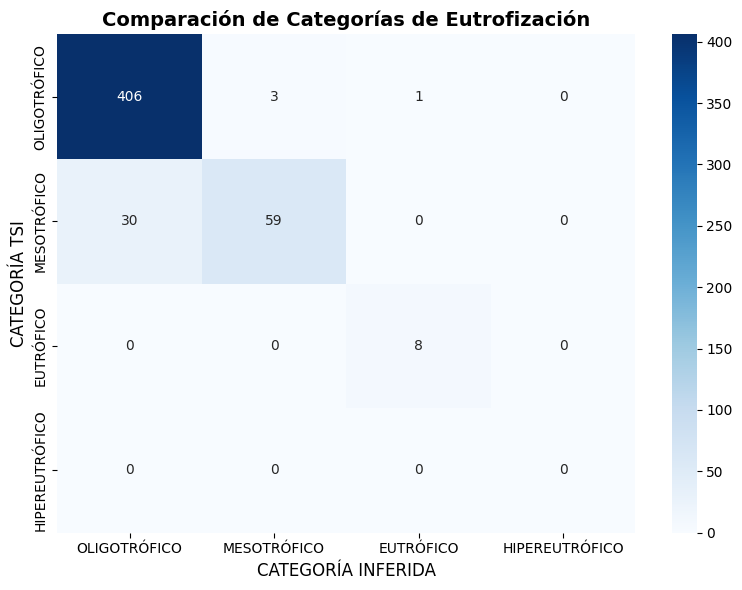

In [40]:
plot_categorical_comparison(
    reporte_eveluacion.get('validacion'),
    reporte_eveluacion.get('inferencia')
)

In [41]:
data_serie = target_data.copy()

In [42]:
data_serie = process_data_in_temporal_space(data_serie, TemporalSpace.MONTHLY)
data_serie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Water Body  332 non-null    object 
 1   Year        332 non-null    int32  
 2   Month       332 non-null    int32  
 3   Chl_a       69 non-null     float64
 4   DIN         0 non-null      float64
 5   DKN         14 non-null     float64
 6   NH3N        70 non-null     float64
 7   NH4N        0 non-null      float64
 8   NOxN        99 non-null     float64
 9   NO2N        0 non-null      float64
 10  NO3N        0 non-null      float64
 11  PN          14 non-null     float64
 12  PON         3 non-null      float64
 13  TDN         0 non-null      float64
 14  TKN         0 non-null      float64
 15  TN          0 non-null      float64
 16  TON         0 non-null      float64
 17  DON         0 non-null      float64
 18  DIP         0 non-null      float64
 19  DRP         106 non-null    f

In [43]:
#Ordenar para garantizar el orden temporal

if _config.temporal_space == TemporalSpace.MONTHLY:
    data_serie = data_serie.sort_values(by=['Year', 'Month'])

if _config.temporal_space == TemporalSpace.WEEKLY:
    data_serie = data_serie.sort_values(by=['Year', 'Week'])

if _config.temporal_space == TemporalSpace.DAILY:
    data_serie = data_serie.sort_values(by=['Year', 'Month', 'Day'])

data_serie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Water Body  332 non-null    object 
 1   Year        332 non-null    int32  
 2   Month       332 non-null    int32  
 3   Chl_a       69 non-null     float64
 4   DIN         0 non-null      float64
 5   DKN         14 non-null     float64
 6   NH3N        70 non-null     float64
 7   NH4N        0 non-null      float64
 8   NOxN        99 non-null     float64
 9   NO2N        0 non-null      float64
 10  NO3N        0 non-null      float64
 11  PN          14 non-null     float64
 12  PON         3 non-null      float64
 13  TDN         0 non-null      float64
 14  TKN         0 non-null      float64
 15  TN          0 non-null      float64
 16  TON         0 non-null      float64
 17  DON         0 non-null      float64
 18  DIP         0 non-null      float64
 19  DRP         106 non-null    f

In [44]:
data_serie = data_serie[numeric_columns + ['Year', 'Month']]
data_serie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chl_a   69 non-null     float64
 1   DKN     14 non-null     float64
 2   NH3N    70 non-null     float64
 3   NOxN    99 non-null     float64
 4   PN      14 non-null     float64
 5   PON     3 non-null      float64
 6   DRP     106 non-null    float64
 7   TDP     14 non-null     float64
 8   TP      131 non-null    float64
 9   O2_Dis  141 non-null    float64
 10  TRANS   145 non-null    float64
 11  TEMP    159 non-null    float64
 12  pH      136 non-null    float64
 13  Year    332 non-null    int32  
 14  Month   332 non-null    int32  
dtypes: float64(13), int32(2)
memory usage: 36.4 KB


In [45]:
def process_data_multivariate(data):
    values = data.values
    num_features = values.shape[1]
    time = data.index.astype(np.int64) // 10**9  # Timestamps en segundos
    time = time.values

    mask = ~np.isnan(values)
    mask = mask.astype(float)

    values_filled = np.nan_to_num(values)

    x_last_obs = np.zeros_like(values)
    delta_t_x = np.zeros_like(values)
    delta_t_h = np.zeros(len(time))

    for i in range(num_features):
        first_obs_idx = np.where(mask[:, i] == 1)[0]
        if len(first_obs_idx) > 0:
            first_idx = first_obs_idx[0]
            x_last_obs[first_idx, i] = values_filled[first_idx, i]
        else:
            first_idx = 0

    for i in range(1, len(time)):
        delta = time[i] - time[i - 1]
        delta_t_h[i] = delta

        for j in range(num_features):
            if mask[i - 1, j]:
                x_last_obs[i, j] = values_filled[i - 1, j]
                delta_t_x[i, j] = delta
            else:
                x_last_obs[i, j] = x_last_obs[i - 1, j]
                delta_t_x[i, j] = delta_t_x[i - 1, j] + delta

    # Opcional: Escalar delta_t_x y delta_t_h
    delta_t_x = delta_t_x / delta_t_x.max()
    delta_t_h = delta_t_h / delta_t_h.max()

    return values_filled, mask, delta_t_x, delta_t_h, x_last_obs

# 1. Preparación de los Datos
tmp_data = data_serie.copy()
tmp_data['Date'] = pd.to_datetime(dict(year=tmp_data.Year, month=tmp_data.Month, day=1))
tmp_data.sort_values('Date', inplace=True)
tmp_data.set_index('Date', inplace=True)
tmp_data.drop(['Year', 'Month'], axis=1, inplace=True)

# 2. Normalización de los Datos
scaler = MinMaxScaler()
x_np = tmp_data.values
x_scaled = scaler.fit_transform(x_np)
data_scaled = pd.DataFrame(x_scaled, index=tmp_data.index, columns=tmp_data.columns)

# 3. Procesamiento de los Datos
values_filled, mask, delta_t_x, delta_t_h, x_last_obs = process_data_multivariate(data_scaled)

# Convertir a tensores
x = torch.tensor(values_filled, dtype=torch.float32)
mask = torch.tensor(mask, dtype=torch.float32)
delta_t_x = torch.tensor(delta_t_x, dtype=torch.float32)
delta_t_h = torch.tensor(delta_t_h, dtype=torch.float32)
x_last_obs = torch.tensor(x_last_obs, dtype=torch.float32)

# 4. Definición del Modelo
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUD, self).__init__()
        self.hidden_size = hidden_size

        self.gamma_x = nn.Parameter(torch.Tensor(input_size))
        self.gamma_h = nn.Parameter(torch.Tensor(hidden_size))

        self.embedding = nn.Linear(input_size * 2, input_size)
        self.gru_cell = nn.GRUCell(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, input_size)
        self.softplus = nn.Softplus()

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.gamma_x, mean=0, std=0.1)
        nn.init.normal_(self.gamma_h, mean=0, std=0.1)
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x, x_last_obs, mask, delta_t_x, delta_t_h, h):
        gamma_x = torch.exp(-torch.relu(self.gamma_x) * delta_t_x)
        gamma_h = torch.exp(-torch.relu(self.gamma_h) * delta_t_h.unsqueeze(-1))

        x = mask * x + (1 - mask) * (gamma_x * x_last_obs)
        h = gamma_h * h

        x_combined = torch.cat([x, mask], dim=-1)
        x_emb = self.embedding(x_combined)
        h = self.gru_cell(x_emb, h)

        # Aplicar Softplus para asegurar salidas positivas
        x_imputed = self.softplus(self.output_layer(h))

        return h, x_imputed

# 5. Configuración del Modelo y Entrenamiento
input_size = x.shape[1]
hidden_size = 32

model = GRUD(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    h = torch.zeros(1, hidden_size)
    loss = 0

    for t in range(len(x)):
        h, x_imputed = model(
            x[t].unsqueeze(0),
            x_last_obs[t].unsqueeze(0),
            mask[t].unsqueeze(0),
            delta_t_x[t].unsqueeze(0),
            delta_t_h[t].unsqueeze(0),
            h
        )
        loss += criterion(
            x_imputed * (1 - mask[t].unsqueeze(0)),
            x[t].unsqueeze(0) * (1 - mask[t].unsqueeze(0))
        )

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# 6. Imputación de Datos Faltantes
model.eval()
with torch.no_grad():
    h = torch.zeros(1, hidden_size)
    imputations = []
    for t in range(len(x)):
        h, x_imputed = model(
            x[t].unsqueeze(0),
            x_last_obs[t].unsqueeze(0),
            mask[t].unsqueeze(0),
            delta_t_x[t].unsqueeze(0),
            delta_t_h[t].unsqueeze(0),
            h
        )
        x_filled = x[t].clone()
        x_filled[mask[t] == 0] = x_imputed.squeeze(0)[mask[t] == 0]
        imputations.append(x_filled.numpy())

imputed_values = np.array(imputations)

# Invertir la escala de las imputaciones
imputed_values_rescaled = scaler.inverse_transform(imputed_values)
imputed_data = pd.DataFrame(imputed_values_rescaled, index=tmp_data.index, columns=tmp_data.columns)

Epoch [1/100], Loss: 126.4142
Epoch [2/100], Loss: 122.7489
Epoch [3/100], Loss: 119.2339
Epoch [4/100], Loss: 115.8578
Epoch [5/100], Loss: 112.6080
Epoch [6/100], Loss: 109.4725
Epoch [7/100], Loss: 106.4389
Epoch [8/100], Loss: 103.4948
Epoch [9/100], Loss: 100.6280
Epoch [10/100], Loss: 97.8272
Epoch [11/100], Loss: 95.0824
Epoch [12/100], Loss: 92.3843
Epoch [13/100], Loss: 89.7236
Epoch [14/100], Loss: 87.0929
Epoch [15/100], Loss: 84.4854
Epoch [16/100], Loss: 81.8955
Epoch [17/100], Loss: 79.3184
Epoch [18/100], Loss: 76.7504
Epoch [19/100], Loss: 74.1885
Epoch [20/100], Loss: 71.6304
Epoch [21/100], Loss: 69.0748
Epoch [22/100], Loss: 66.5210
Epoch [23/100], Loss: 63.9689
Epoch [24/100], Loss: 61.4195
Epoch [25/100], Loss: 58.8743
Epoch [26/100], Loss: 56.3359
Epoch [27/100], Loss: 53.8075
Epoch [28/100], Loss: 51.2941
Epoch [29/100], Loss: 48.8013
Epoch [30/100], Loss: 46.3335
Epoch [31/100], Loss: 43.9004
Epoch [32/100], Loss: 41.5077
Epoch [33/100], Loss: 39.1603
Epoch [34/

In [46]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 332 entries, 1979-03-01 to 2006-10-01
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Chl_a   332 non-null    float32
 1   DKN     332 non-null    float32
 2   NH3N    332 non-null    float32
 3   NOxN    332 non-null    float32
 4   PN      332 non-null    float32
 5   PON     332 non-null    float32
 6   DRP     332 non-null    float32
 7   TDP     332 non-null    float32
 8   TP      332 non-null    float32
 9   O2_Dis  332 non-null    float32
 10  TRANS   332 non-null    float32
 11  TEMP    332 non-null    float32
 12  pH      332 non-null    float32
dtypes: float32(13)
memory usage: 19.5 KB


In [47]:
imputed_data = imputed_data.reset_index(drop=True)

In [48]:
scaler = StandardScaler()
scaled_fox = scaler.fit_transform(data_serie[numeric_columns])
knn_imputer = KNNImputer(n_neighbors=12, weights='uniform')
knn_data = pd.DataFrame(knn_imputer.fit_transform(scaled_fox), columns=numeric_columns)

In [49]:
data_sub = knn_data.copy()

# Seleccionar las características relevantes
features = numeric_columns
dataset = data_sub[features].values

# Función para crear secuencias
def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # Tamaño de la ventana temporal
X, y = create_sequences(dataset, window_size)
num_features = X.shape[2]

# División en entrenamiento y prueba
train_size = int(len(X) * 0.80)
X_train, X_test = X[:], X[train_size:]
y_train, y_test = y[:], y[train_size:]

# Construcción del modelo con capa Input explícita
model = Sequential()
model.add(Input(shape=(window_size, num_features)))  # Capa de entrada
model.add(LSTM(512))         # Capa LSTM sin input_shape
model.add(Dense(num_features))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

early_stopping = EarlyStopping(
    monitor='loss',                   # Métrica a monitorear
    patience=10,                      # Número de épocas sin mejora antes de detener
    verbose=0,                        # Nivel de verbosidad
    mode='min',                       # Minimizar val_loss
    restore_best_weights=True         # Restaurar los mejores pesos al finalizar
)

_h = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[
        early_stopping
    ]
)

# Generación de predicciones futuras
future_predictions = []
last_sequence = X[-1]

for _ in range(imputed_data.shape[0]):
    # Realiza la predicción
    next_pred = model.predict(last_sequence.reshape(1, window_size, num_features))

    # Agrega la predicción a la lista de predicciones futuras
    future_predictions.append(next_pred[0])

    # Actualiza la última secuencia:
    # Método 1: Usando np.append sin corchetes
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

    # Método 2: Usando np.concatenate
    # last_sequence = np.concatenate((last_sequence[1:], next_pred), axis=0)

    # Método 3: Usando np.vstack
    # last_sequence = np.vstack((last_sequence[1:], next_pred))

# Creación del DataFrame con las predicciones
crazy_predictions = pd.DataFrame(future_predictions, columns=features)
crazy_predictions[numeric_columns] = scaler.inverse_transform(crazy_predictions[numeric_columns])

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.2684 - val_loss: 0.0904
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.2566 - val_loss: 0.0894
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.2480 - val_loss: 0.0887
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.2402 - val_loss: 0.0883
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.2326 - val_loss: 0.0881
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.2253 - val_loss: 0.0881
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.2191 - val_loss: 0.0883
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.2146 - val_loss: 0.0883
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.2114 - val_loss: 0.0882
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.2087 - val_loss: 0.0880
Epoch 11/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.2063 - val_loss: 0.0879
Epoch 12/1000
20/20 ━━━━━━━━━━

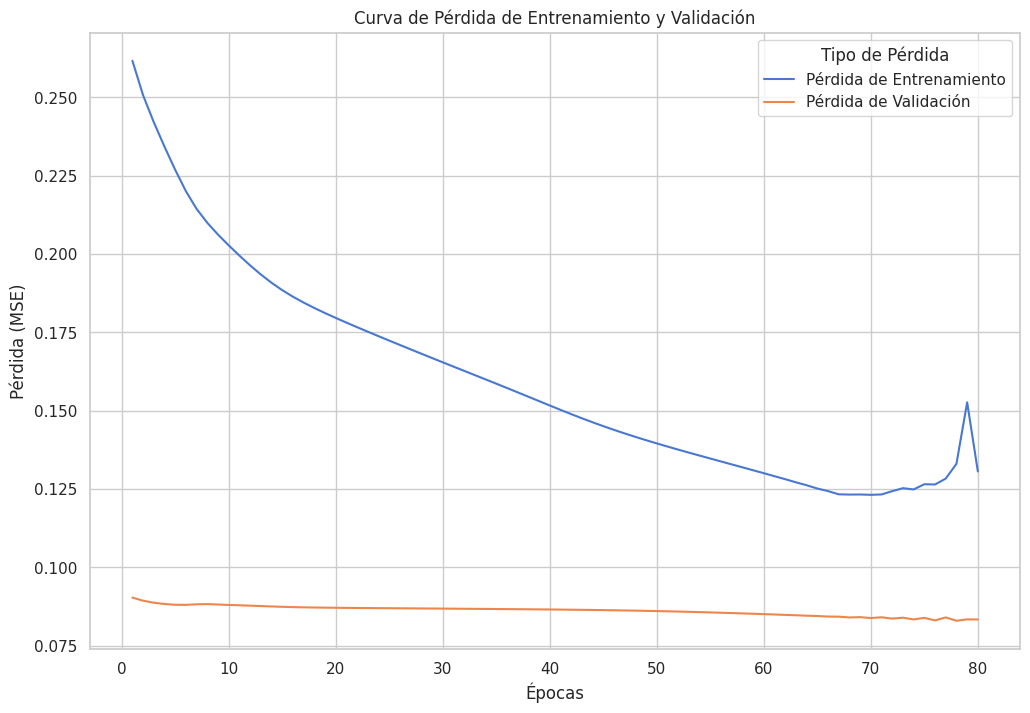

In [50]:
plot_training_history_sns(_h)

In [51]:
data_serie_filled = data_serie.copy()

for column in data_serie.columns:
  for index in data_serie.index:
    if pd.isnull(data_serie.loc[index, column]):
      imputed_value = imputed_data.loc[index, column]
      crazy_prediction_value = crazy_predictions.loc[index, column]
      data_serie_filled.loc[index, column] = (imputed_value * 0.7) + (crazy_prediction_value * 0.3)

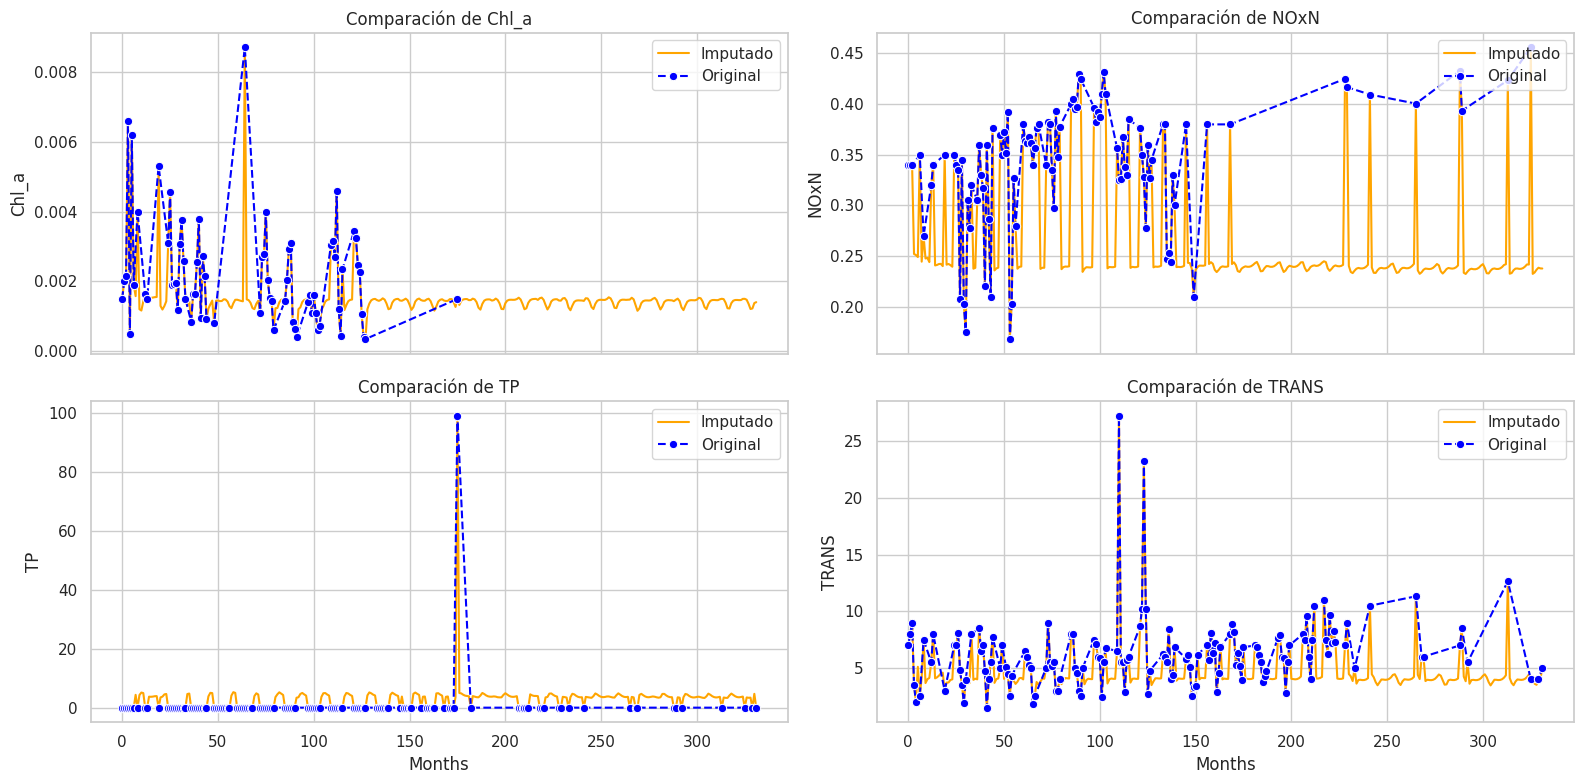

In [53]:
plot_original_vs_model(data_serie, data_serie_filled, ['Chl_a', 'NOxN', 'TP', 'TRANS'], num_rows=crazy_predictions.shape[0], labels=['Original', 'Imputado'])

In [54]:
fuz_data_serie, _, _ = ejecutar_motor(data_serie_filled)

In [55]:
fuz_vars = ['eutrofizacion', 'quimicas', 'fisicas', 'adicionales']
fuz_data = {
    'eutrofizacion': [],
    'quimicas': [],
    'fisicas': [],
    'adicionales': []
}

for i in fuz_data_serie:
    for c in fuz_vars:
        fuz_data[c].append(i[c]['valor'])

fuz_data = pd.DataFrame(fuz_data)
fuz_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   eutrofizacion  332 non-null    float64
 1   quimicas       332 non-null    float64
 2   fisicas        332 non-null    float64
 3   adicionales    332 non-null    float64
dtypes: float64(4)
memory usage: 10.5 KB


In [56]:
validation_predict = fuz_data.iloc[-1*_config.predict_len:]
validation_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 320 to 331
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   eutrofizacion  12 non-null     float64
 1   quimicas       12 non-null     float64
 2   fisicas        12 non-null     float64
 3   adicionales    12 non-null     float64
dtypes: float64(4)
memory usage: 516.0 bytes


In [57]:
train_data = fuz_data.iloc[:-1*_config.predict_len]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   eutrofizacion  320 non-null    float64
 1   quimicas       320 non-null    float64
 2   fisicas        320 non-null    float64
 3   adicionales    320 non-null    float64
dtypes: float64(4)
memory usage: 10.1 KB


In [58]:
data_sub = train_data.copy()

# Seleccionar las características relevantes
features = ['eutrofizacion', 'quimicas', 'fisicas', 'adicionales']
dataset = data_sub[features].values

# Función para crear secuencias
def create_sequences(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # Tamaño de la ventana temporal
X, y = create_sequences(dataset, window_size)
num_features = X.shape[2]

# División en entrenamiento y prueba
train_size = int(len(X) * 0.75)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Construcción del modelo con capa Input explícita
model = Sequential()
model.add(Input(shape=(window_size, num_features)))  # Capa de entrada
model.add(LSTM(64))         # Capa LSTM sin input_shape
model.add(Dense(num_features))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

In [59]:
early_stopping = EarlyStopping(
    monitor='val_loss',               # Métrica a monitorear
    patience=10,                      # Número de épocas sin mejora antes de detener
    verbose=0,                        # Nivel de verbosidad
    mode='min',                       # Minimizar val_loss
    min_delta=0.0001,                 # Mínimo cambio permitido en la métrica
    restore_best_weights=True         # Restaurar los mejores pesos al finalizar
)

_h = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=[
        early_stopping
    ]
)

Epoch 1/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0645 - val_loss: 0.0163
Epoch 2/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - val_loss: 0.0160
Epoch 3/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - val_loss: 0.0156
Epoch 4/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - val_loss: 0.0153
Epoch 5/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0227 - val_loss: 0.0150
Epoch 6/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0223 - val_loss: 0.0147
Epoch 7/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0219 - val_loss: 0.0144
Epoch 8/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0214 - val_loss: 0.0141
Epoch 9/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - val_loss: 0.0139
Epoch 10/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0205 - val_loss: 0.0136
Epoch 11/1000
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0200 - val_loss: 0.0134
Epoch 12/1000
231/231 ━━━━━━━━

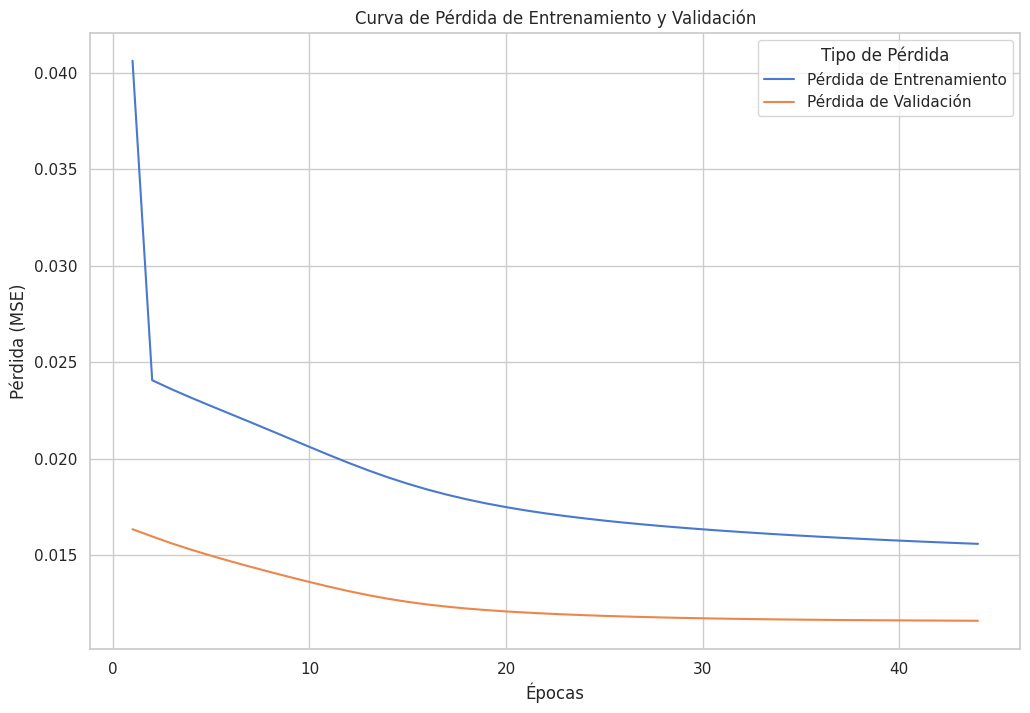

In [60]:
plot_training_history_sns(_h)

In [61]:
# Generación de predicciones futuras
future_predictions = []
last_sequence = X[-1]

for _ in range(12):
    # Realiza la predicción
    next_pred = model.predict(last_sequence.reshape(1, window_size, num_features))

    # Agrega la predicción a la lista de predicciones futuras
    future_predictions.append(next_pred[0])

    # Actualiza la última secuencia:
    # Método 1: Usando np.append sin corchetes
    last_sequence = np.append(last_sequence[1:], next_pred, axis=0)

    # Método 2: Usando np.concatenate
    # last_sequence = np.concatenate((last_sequence[1:], next_pred), axis=0)

    # Método 3: Usando np.vstack
    # last_sequence = np.vstack((last_sequence[1:], next_pred))

# Creación del DataFrame con las predicciones
fuz_predictions = pd.DataFrame(future_predictions, columns=features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [62]:
_mn = {
    'eutrofizacion': 'Nivel de Eutrofización',
    'quimicas': 'Condiciones Químicas',
    'fisicas': 'Condiciones Físicas',
    'adicionales': 'Condiciones Adicionales'
}

vp = validation_predict.rename(columns=_mn)
fp = fuz_predictions.rename(columns=_mn)

In [63]:
train_data

,eutrofizacion,quimicas,fisicas,adicionales
0,0.126667,0.45,0.126667,0.155556
1,0.126667,0.45,0.126667,0.155556
2,0.126667,0.45,0.126667,0.155556
3,0.400000,0.45,0.400000,0.185511
4,0.650000,0.45,0.650000,0.155556
...,...,...,...,...
315,0.400000,0.45,0.400000,0.500000
316,0.400000,0.45,0.400000,0.500000
317,0.400000,0.45,0.400000,0.369886
318,0.400000,0.45,0.400000,0.258207


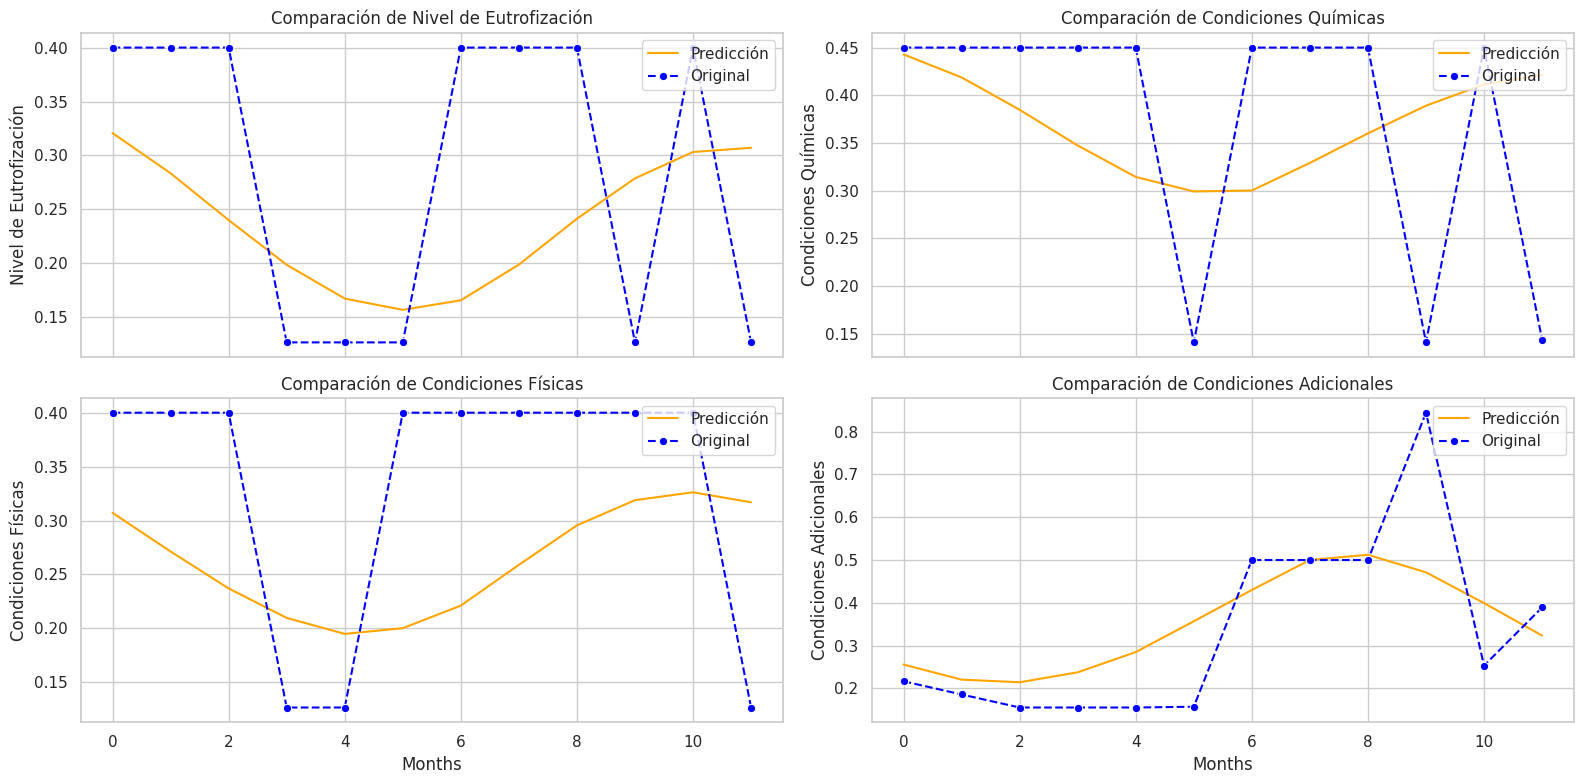

In [64]:
plot_original_vs_model(vp, fp, _mn.values(), num_rows=fuz_predictions.shape[0], labels=['Original', 'Predicción'], x_scale="Months")

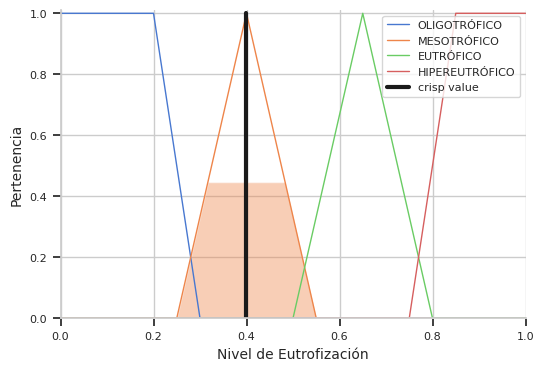

In [65]:
originals = []
predicts = []
fuzis = []

for i in range(validation_predict.shape[0]):
    a = NivelEutrofizacion(validation_predict.iloc[i]['quimicas'], validation_predict.iloc[i]['fisicas'], validation_predict.iloc[i]['adicionales'])
    a.calcular_inferencia()
    originals.append(a.obtener_etiqueta())

    a = NivelEutrofizacion(fuz_predictions.iloc[i]['quimicas'], fuz_predictions.iloc[i]['fisicas'], fuz_predictions.iloc[i]['adicionales'])
    a.calcular_inferencia()
    fuzis.append(a.obtener_etiqueta())

    if i == validation_predict.shape[0]-1:
        a.nivel_eutrofizacion_var.view(sim=a.simulation)
        # Ajustar las etiquetas de los ejes
        fig = plt.gcf()
        fig.set_size_inches(6, 4)
        ax = plt.gca()
        ax.set_xlabel("Nivel de Eutrofización", fontsize=10)
        ax.set_ylabel("Pertenencia", fontsize=10)

        # Ajustar la posición de la leyenda
        ax.legend(loc="upper right", fontsize=8)

        ax.tick_params(axis='both', which='major', labelsize=8)

    a = NivelEutrofizacion(0, 0, 0)
    a.nivel_eutrofizacion = fuz_predictions.iloc[i]['eutrofizacion']
    predicts.append(a.obtener_etiqueta())

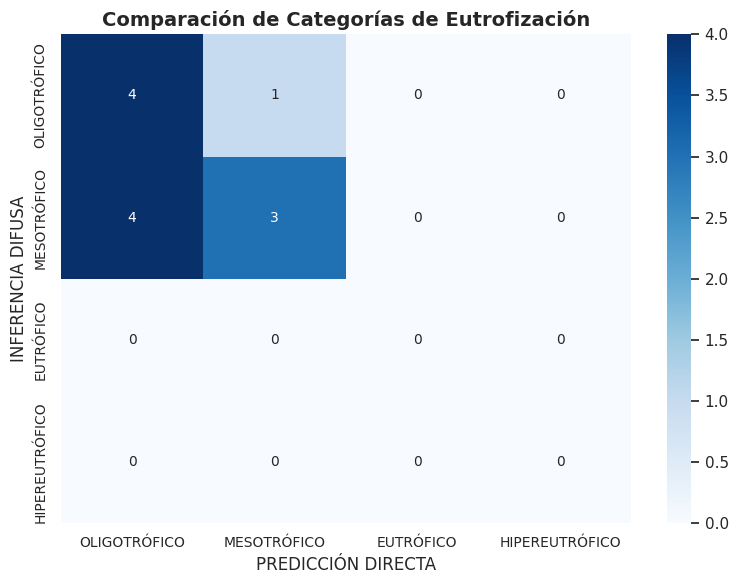

In [66]:
plot_categorical_comparison(originals, predicts, x_label="PREDICCIÓN DIRECTA", y_label="INFERENCIA DIFUSA")

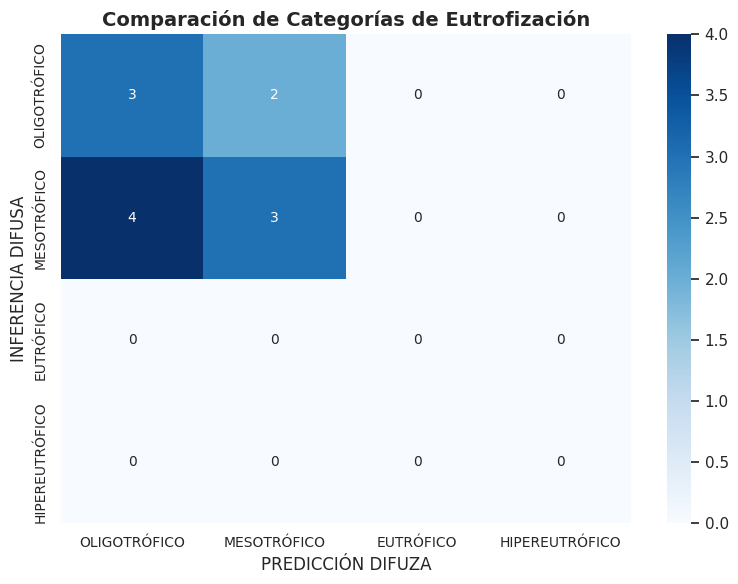

In [67]:
plot_categorical_comparison(originals, fuzis, x_label="PREDICCIÓN DIFUZA", y_label="INFERENCIA DIFUSA")

In [68]:
last_series = data_serie_filled.iloc[-12:]

In [69]:
tsi_s = []
for index, row in last_series.iterrows():
    tsi = calculate_tsi_individual(np.nan, np.nan, row['Chl_a']*1000)
    tsi_s.append(tsi['Level_Chl_a'])

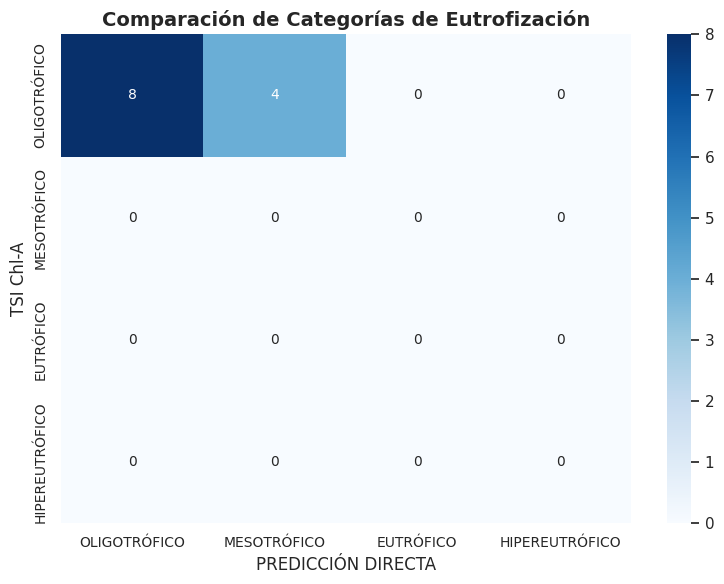

In [70]:
plot_categorical_comparison(tsi_s, predicts, x_label="PREDICCIÓN DIRECTA", y_label="TSI Chl-A")

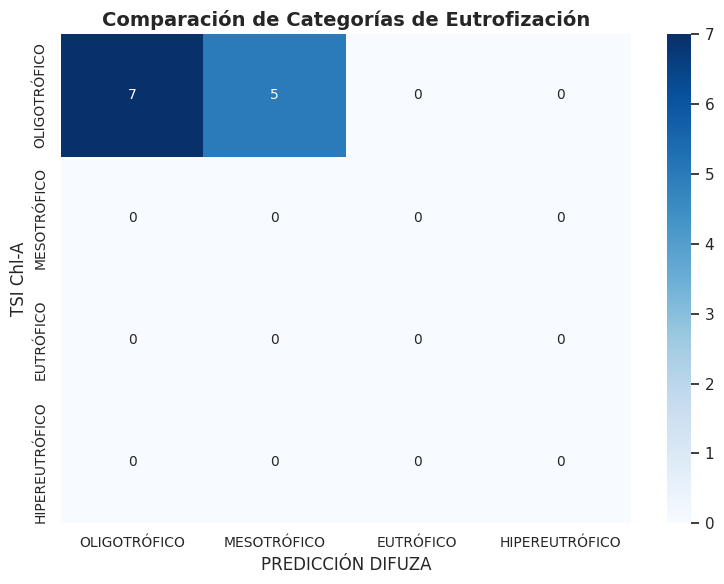

In [71]:
plot_categorical_comparison(tsi_s, fuzis, x_label="PREDICCIÓN DIFUZA", y_label="TSI Chl-A")